<a href="https://colab.research.google.com/github/nailfurkanacar/stock-price-prediction/blob/main/univariate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

connect the drive to get the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = 'drive/My Drive/Colab Notebooks/Senior Project'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [ ]:
pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.2)


In [ ]:
import pandas as pd
import numpy as np
import math


import matplotlib.pyplot as plt
import matplotlib.dates 
import seaborn as sns
#from statsmodels.tsa.seasonal import STL

from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from kerastuner.tuners import RandomSearch

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Sorting and Filtering

In [ ]:
# dataların dizilisini gunumuzden gecmise siralama

def data_sorter(table):
    table = table[::-1] 
    table.reset_index(inplace=True, drop=True)  #to reset the dataframe
    return table

In [ ]:
# to set the time filter for the dataframes

def data_filter_by_time(table):
    start = pd.to_datetime('1986-01-01')
    end = pd.to_datetime('2017-06-15')
    table = table.loc[(table['Date'] >= start) & (table['Date'] <= end)] 
    table.reset_index(inplace=True, drop=True)
    return table

# FEDFUNDS

In [ ]:
fedfunds = pd.read_csv(path + '/FEDFUNDS.csv') #fred.stlouisfed.org 'dan elde edildi, Intereset rate

fedfunds # aylık degisiyor

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
794,2020-09-01,0.09
795,2020-10-01,0.09
796,2020-11-01,0.09
797,2020-12-01,0.09


In [ ]:
fedfunds.rename(columns={'DATE':'Date', 'FEDFUNDS':'fedfunds'}, inplace = True)
fedfunds['Date'] = pd.to_datetime(fedfunds['Date'], format = '%Y-%m-%d')  #tarih formatlarini ayni formata getirme
fedfunds

,Date,fedfunds
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
794,2020-09-01,0.09
795,2020-10-01,0.09
796,2020-11-01,0.09
797,2020-12-01,0.09


In [ ]:
fedfunds = data_sorter(fedfunds) 

In [ ]:
fedfunds = data_filter_by_time(fedfunds)

In [ ]:
fedfunds

,Date,fedfunds
0,2017-06-01,1.04
1,2017-05-01,0.91
2,2017-04-01,0.90
3,2017-03-01,0.79
4,2017-02-01,0.66
...,...,...
373,1986-05-01,6.85
374,1986-04-01,6.99
375,1986-03-01,7.48
376,1986-02-01,7.86


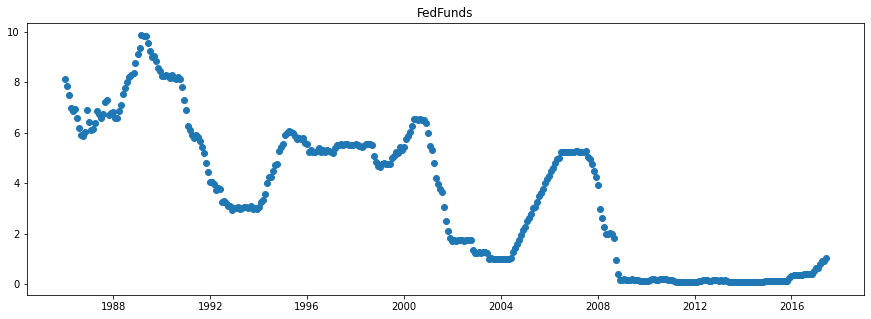

In [ ]:
plt.figure(figsize=(15,5))
plt.title('FedFunds')
plt.scatter(x="Date", y = "fedfunds", data = fedfunds)

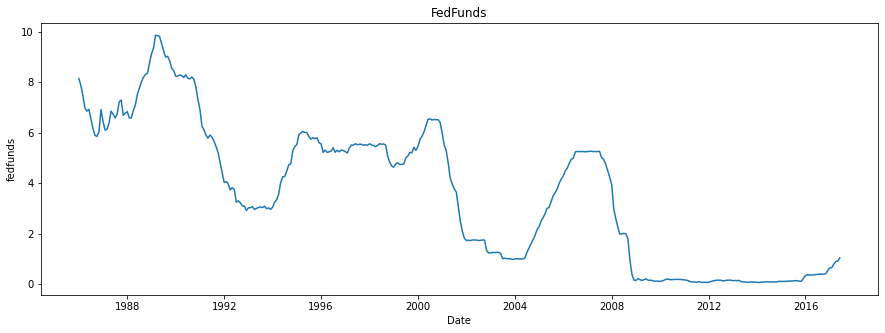

In [ ]:
plt.figure(figsize=(15,5))
plt.title('FedFunds')
sns.lineplot(x="Date", y = "fedfunds", data = fedfunds)

In [ ]:
fedfunds.dtypes

Date        datetime64[ns]
fedfunds           float64
dtype: object

# xau_usd_v2

In [ ]:
# https://stooq.com/q/d/l/?s=xauusd&d1=19700101&d2=20210316&i=d

In [ ]:
xau_usd_v2 = pd.read_csv(path + '/xauusd_d.csv') #gunluk degisiyor
xau_usd_v2

,Date,Open,High,Low,Close
0,1970-01-05,35.40,35.40,35.40,35.40
1,1970-01-06,35.40,35.40,35.20,35.20
2,1970-01-07,35.20,35.20,35.20,35.20
3,1970-01-08,35.20,35.20,35.10,35.10
4,1970-01-09,35.10,35.10,35.10,35.10
...,...,...,...,...,...
13022,2021-03-09,1683.48,1720.69,1680.31,1716.17
13023,2021-03-10,1716.11,1726.89,1708.26,1726.72
13024,2021-03-11,1726.76,1739.91,1719.47,1722.60
13025,2021-03-12,1722.34,1727.98,1699.35,1724.54


In [ ]:
xau_usd_v2['Date'] = pd.to_datetime(xau_usd_v2['Date'], format = '%Y-%m-%d') #tarih formatlarini ayni formata getirme

In [ ]:
xau_usd_v2.drop(["Open", "High", "Low"],axis = 1, inplace = True) 

In [ ]:
xau_usd_v2.rename(columns={"Close": "xau_usd"}, inplace = True)

In [ ]:
xau_usd_v2 = data_filter_by_time(xau_usd_v2)

In [ ]:
xau_usd_v2 = data_sorter(xau_usd_v2)

In [ ]:
#pd.set_option('display.max_rows', None)  #bütün datayı gösterebilmek için
xau_usd_v2

,Date,xau_usd
0,2017-06-15,1254.89
1,2017-06-14,1261.26
2,2017-06-13,1266.31
3,2017-06-12,1266.19
4,2017-06-09,1267.65
...,...,...
8049,1986-01-08,336.10
8050,1986-01-07,332.80
8051,1986-01-06,330.70
8052,1986-01-03,330.00


In [ ]:
xau_usd_v2.dtypes

Date       datetime64[ns]
xau_usd           float64
dtype: object

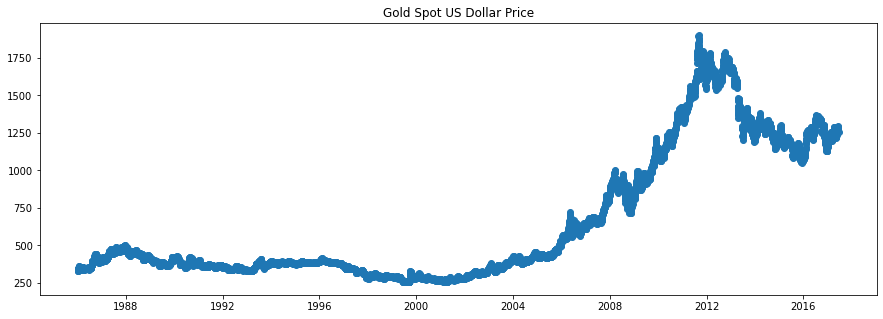

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Gold Spot US Dollar Price')
plt.scatter(x="Date", y="xau_usd", data = xau_usd_v2)

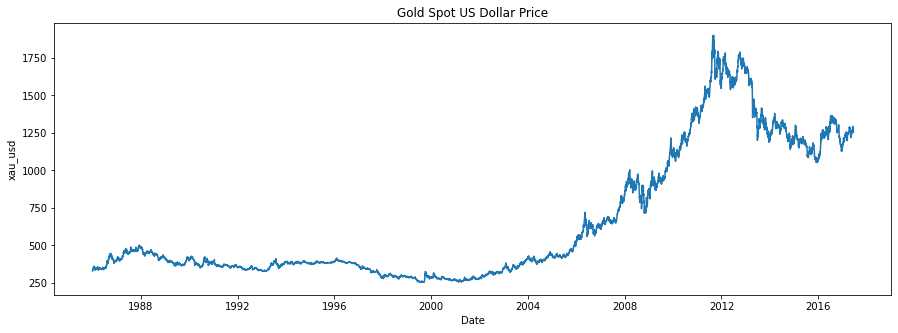

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Gold Spot US Dollar Price')
sns.lineplot(x="Date", y = "xau_usd", data = xau_usd_v2)

# Gross Domestic Product(GDP) of US 

In [ ]:
gdp_us = pd.read_csv(path + '/UNAE-GDPCDPC_USA.csv') #GDP degerleri, yıllık degisiyor 2020 yok, 2020 yerine 2019
gdp_us.head(10)

,Date,Gross Domestic Product (GDP)
0,2019-12-31,65133.731652
1,2018-12-31,63014.663283
2,2017-12-31,60116.568493
3,2016-12-31,58031.414203
4,2015-12-31,56838.684422
5,2014-12-31,55000.691601
6,2013-12-31,53049.375662
7,2012-12-31,51575.616573
8,2011-12-31,49882.470395
9,2010-12-31,48516.165945


In [ ]:
gdp_us.rename(columns={'Gross Domestic Product (GDP)':'GDP'}, inplace = True)

In [ ]:
gdp_us['Date'] = pd.to_datetime(gdp_us['Date'], format = '%Y-%m-%d') #tarih formatlarini ayni formata getirme
gdp_us.dtypes

Date    datetime64[ns]
GDP            float64
dtype: object

In [ ]:
gdp_us = data_filter_by_time(gdp_us)
gdp_us.head(10)

,Date,GDP
0,2016-12-31,58031.414203
1,2015-12-31,56838.684422
2,2014-12-31,55000.691601
3,2013-12-31,53049.375662
4,2012-12-31,51575.616573
5,2011-12-31,49882.470395
6,2010-12-31,48516.165945
7,2009-12-31,47171.319147
8,2008-12-31,48479.483133
9,2007-12-31,48075.365179


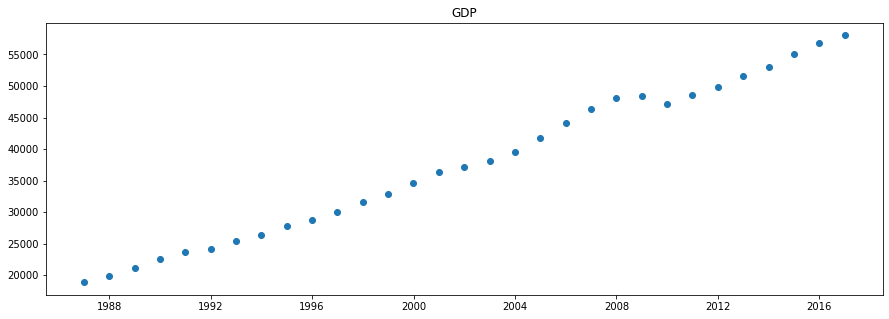

In [ ]:
plt.figure(figsize=(15,5))
plt.title('GDP')
plt.scatter(x="Date", y="GDP", data = gdp_us)

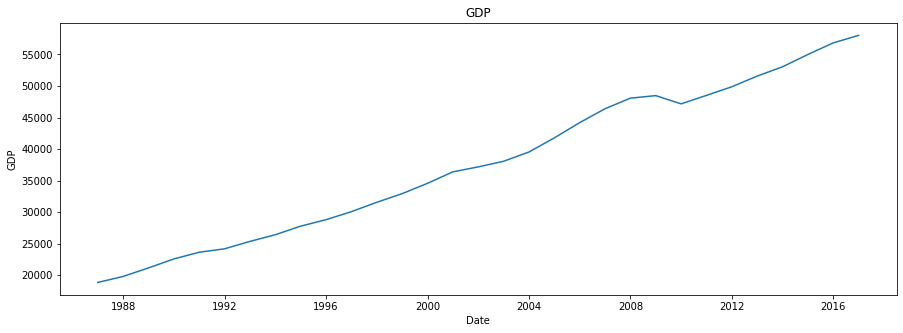

In [ ]:
plt.figure(figsize=(15,5))
plt.title('GDP')
sns.lineplot(x="Date", y="GDP", data = gdp_us)

# Consumer Price Index(CPI) values of US

In [ ]:
cpi_us = pd.read_csv(path + '/RATEINF-CPI_USA.csv') #aylık degisiyor
cpi_us

,Date,Value
0,2021-01-31,261.582
1,2020-12-31,260.474
2,2020-11-30,260.229
3,2020-10-31,260.388
4,2020-09-30,260.280
...,...,...
1292,1913-05-31,9.700
1293,1913-04-30,9.800
1294,1913-03-31,9.800
1295,1913-02-28,9.800


In [ ]:
cpi_us.rename(columns={'Value':'CPI'}, inplace = True)

In [ ]:
cpi_us['Date'] = pd.to_datetime(cpi_us['Date'], format = '%Y-%m-%d') #tarih formatlarini ayni formata getirme
cpi_us.dtypes 

Date    datetime64[ns]
CPI            float64
dtype: object

In [ ]:
cpi_us = data_filter_by_time(cpi_us)
cpi_us

,Date,CPI
0,2017-05-31,244.733
1,2017-04-30,244.524
2,2017-03-31,243.801
3,2017-02-28,243.603
4,2017-01-31,242.839
...,...,...
372,1986-05-31,108.900
373,1986-04-30,108.600
374,1986-03-31,108.800
375,1986-02-28,109.300


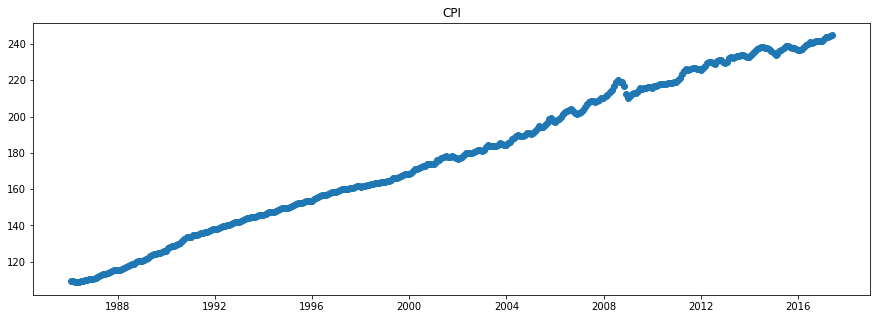

In [ ]:
plt.figure(figsize=(15,5))
plt.title('CPI')
plt.scatter(x="Date", y = "CPI", data = cpi_us)

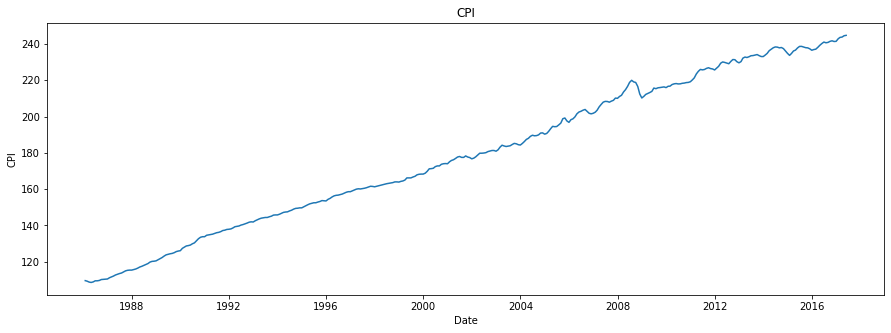

In [ ]:
plt.figure(figsize=(15,5))
plt.title('CPI')
sns.lineplot(x="Date", y = "CPI", data = cpi_us)

# Inflation Ratio of US

In [ ]:
# https://fred.stlouisfed.org/series/FPCPITOTLZGUSA

In [ ]:
inflation_us = pd.read_csv(path + '/inflation_rate_us.csv') #enflasyon(US) verileri mevcut ve yıllık değişiyor
inflation_us

,DATE,FPCPITOTLZGUSA
0,1960-01-01,1.457976
1,1961-01-01,1.070724
2,1962-01-01,1.198773
3,1963-01-01,1.239669
4,1964-01-01,1.278912
...,...,...
57,2017-01-01,2.130110
58,2018-01-01,2.442583
59,2019-01-01,1.812210
60,2020-01-01,0.620000


In [ ]:
inflation_us.rename(columns={'DATE':'Date', 'FPCPITOTLZGUSA' : 'Inflation_Rate'}, inplace = True)

In [ ]:
inflation_us['Date'] = pd.to_datetime(inflation_us['Date'], format = '%Y-%m-%d') #tarih formatlarini ayni formata getirme
inflation_us.dtypes

Date              datetime64[ns]
Inflation_Rate           float64
dtype: object

In [ ]:
inflation_us = data_sorter(inflation_us)

In [ ]:
inflation_us = data_filter_by_time(inflation_us)

In [ ]:
inflation_us.head(10)

,Date,Inflation_Rate
0,2017-01-01,2.130110
1,2016-01-01,1.261583
2,2015-01-01,0.118627
3,2014-01-01,1.622223
4,2013-01-01,1.464833
5,2012-01-01,2.069337
6,2011-01-01,3.156842
7,2010-01-01,1.640043
8,2009-01-01,-0.355546
9,2008-01-01,3.839100


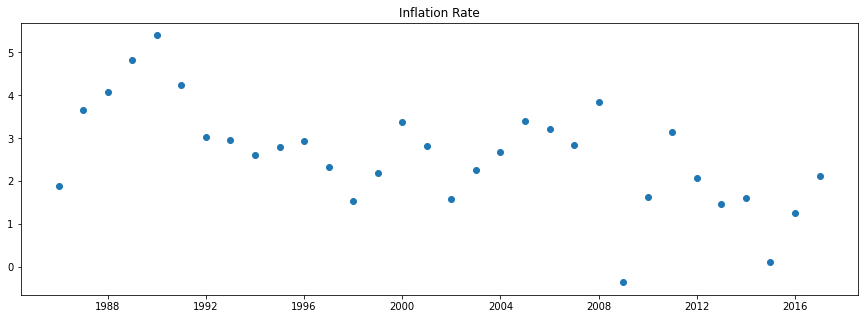

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Inflation Rate')
plt.scatter(x="Date", y = "Inflation_Rate", data = inflation_us)

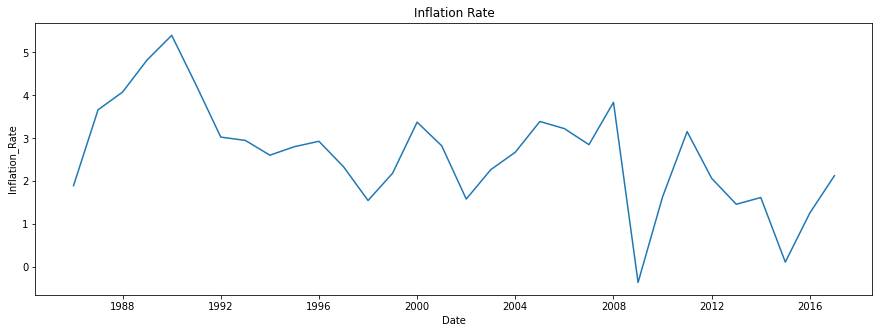

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Inflation Rate')
sns.lineplot(x="Date", y = "Inflation_Rate", data = inflation_us)

# IXIC - NASDAQ

In [ ]:
nasdaq_all = pd.read_csv(path + '/IXIC.csv') #yahoo finance 'den elde edildi (date range: max : 1971-2021)
#nasdaq = pd.read_csv(path + '/AAL.csv') #yahoo finance 'den elde edildi 
nasdaq_all

,Date,Open,High,Low,Close,Adj Close,Volume
0,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
2,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
3,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
4,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0
...,...,...,...,...,...,...,...
12631,2021-03-08,12904.259766,13001.000000,12599.230469,12609.160156,12609.160156,5971260000
12632,2021-03-09,12923.070313,13151.540039,12882.490234,13073.820313,13073.820313,6294910000
12633,2021-03-10,13234.730469,13277.110352,13035.440430,13068.830078,13068.830078,5991730000
12634,2021-03-11,13273.309570,13433.620117,13246.330078,13398.669922,13398.669922,5956260000


In [ ]:
nasdaq = nasdaq_all
nasdaq.drop(["Open", "High", "Low", "Adj Close"], axis = 1, inplace = True)  #fiyat bilgisi icin "Close" kullanildi

nasdaq['Date'] = pd.to_datetime(nasdaq['Date'], format = '%Y-%m-%d') #tarih formatlarini ayni formata getirme
nasdaq.dtypes

Date      datetime64[ns]
Close            float64
Volume             int64
dtype: object

In [ ]:
nasdaq = data_sorter(nasdaq)

In [ ]:
nasdaq = data_filter_by_time(nasdaq)

In [ ]:
nasdaq

,Date,Close,Volume
0,2017-06-15,6165.500000,1858130000
1,2017-06-14,6194.890137,1940440000
2,2017-06-13,6220.370117,2062110000
3,2017-06-12,6175.459961,2586540000
4,2017-06-09,6207.919922,3152050000
...,...,...,...
7925,1986-01-08,328.100006,140000000
7926,1986-01-07,329.700012,127500000
7927,1986-01-06,326.000000,99240000
7928,1986-01-03,325.700012,89180000


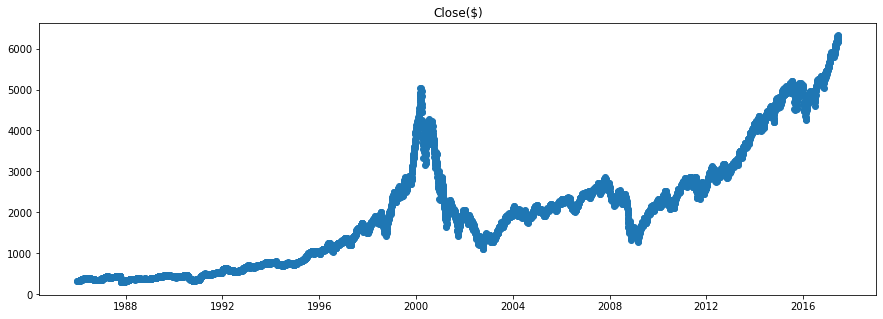

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Close($)')
plt.scatter(x="Date", y="Close", data = nasdaq)

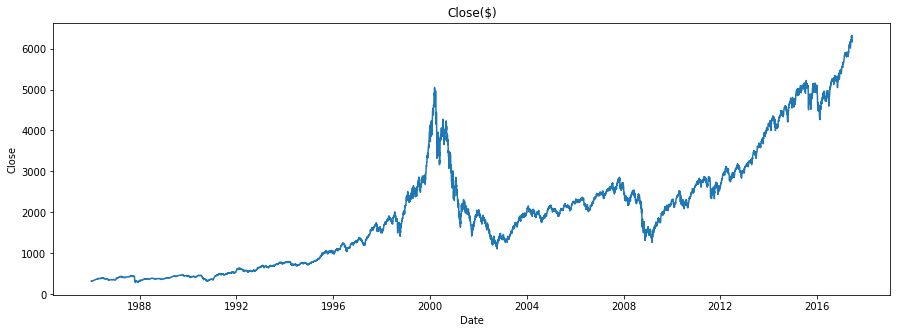

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Close($)')
sns.lineplot(x="Date", y="Close", data = nasdaq)

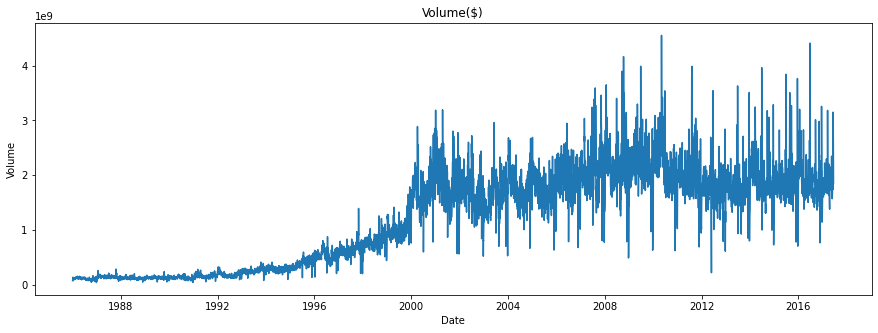

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Volume($)')
sns.lineplot(x="Date", y="Volume", data = nasdaq)

In [ ]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7930 entries, 0 to 7929
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7930 non-null   datetime64[ns]
 1   Close   7930 non-null   float64       
 2   Volume  7930 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 186.0 KB


In [ ]:
nasdaq.describe()

,Close,Volume
count,7930.000000,7.930000e+03
mean,2003.388711,1.210604e+09
std,1407.746786,8.457335e+08
min,291.899994,4.404000e+07
25%,726.747513,2.697000e+08
50%,1890.994995,1.471800e+09
75%,2642.755005,1.901830e+09
max,6321.759766,4.553600e+09


In [ ]:
nasdaq.isnull().any()

Date      False
Close     False
Volume    False
dtype: bool

# Concetination of DataFrames

In [ ]:
#“Merging” two datasets is the process of bringing two datasets together into one
# outer: use union of keys from both frames,

all_data = pd.merge(nasdaq, fedfunds, how ="outer", on=["Date"]) 
all_data = pd.merge(all_data, xau_usd_v2, how ="outer", on=["Date"])
all_data = pd.merge(all_data, gdp_us, how ="outer", on=["Date"])
all_data = pd.merge(all_data, cpi_us, how ="outer", on=["Date"])
all_data = pd.merge(all_data, inflation_us, how="outer", on=["Date"])

In [ ]:
all_data = all_data.sort_values(by='Date')
#all_data = data_sorter(all_data)
all_data = data_filter_by_time(all_data)

In [ ]:
#pd.set_option('display.max_rows', None)  #bütün datayı gösterebilmek için
all_data

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
0,1986-01-01,NaN,NaN,8.14,NaN,NaN,NaN,1.898048
1,1986-01-02,325.000000,7.581000e+07,NaN,328.90,NaN,NaN,NaN
2,1986-01-03,325.700012,8.918000e+07,NaN,330.00,NaN,NaN,NaN
3,1986-01-06,326.000000,9.924000e+07,NaN,330.70,NaN,NaN,NaN
4,1986-01-07,329.700012,1.275000e+08,NaN,332.80,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8330,2017-06-09,6207.919922,3.152050e+09,NaN,1267.65,NaN,NaN,NaN
8331,2017-06-12,6175.459961,2.586540e+09,NaN,1266.19,NaN,NaN,NaN
8332,2017-06-13,6220.370117,2.062110e+09,NaN,1266.31,NaN,NaN,NaN
8333,2017-06-14,6194.890137,1.940440e+09,NaN,1261.26,NaN,NaN,NaN


In [ ]:
columns_for_previos = ["Close", "Volume", "fedfunds", "xau_usd", "GDP","CPI", "Inflation_Rate"]
all_data.update(all_data[columns_for_previos].fillna(method="bfill",axis=0))

In [ ]:
all_data

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
0,1986-01-01,325.000000,7.581000e+07,8.14,328.90,18864.60543,109.6,1.898048
1,1986-01-02,325.000000,7.581000e+07,7.86,328.90,18864.60543,109.6,3.664563
2,1986-01-03,325.700012,8.918000e+07,7.86,330.00,18864.60543,109.6,3.664563
3,1986-01-06,326.000000,9.924000e+07,7.86,330.70,18864.60543,109.6,3.664563
4,1986-01-07,329.700012,1.275000e+08,7.86,332.80,18864.60543,109.6,3.664563
...,...,...,...,...,...,...,...,...
8330,2017-06-09,6207.919922,3.152050e+09,NaN,1267.65,NaN,NaN,NaN
8331,2017-06-12,6175.459961,2.586540e+09,NaN,1266.19,NaN,NaN,NaN
8332,2017-06-13,6220.370117,2.062110e+09,NaN,1266.31,NaN,NaN,NaN
8333,2017-06-14,6194.890137,1.940440e+09,NaN,1261.26,NaN,NaN,NaN


In [ ]:
#pd.set_option('display.max_rows', None)  #bütün datayı gösterebilmek için
all_data.tail(10)

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
8325,2017-06-02,6305.799805,1.820000e+09,NaN,1278.29,NaN,NaN,NaN
8326,2017-06-05,6295.680176,1.739820e+09,NaN,1276.57,NaN,NaN,NaN
8327,2017-06-06,6275.060059,1.889690e+09,NaN,1293.83,NaN,NaN,NaN
8328,2017-06-07,6297.379883,1.822270e+09,NaN,1287.49,NaN,NaN,NaN
8329,2017-06-08,6321.759766,2.128780e+09,NaN,1277.27,NaN,NaN,NaN
8330,2017-06-09,6207.919922,3.152050e+09,NaN,1267.65,NaN,NaN,NaN
8331,2017-06-12,6175.459961,2.586540e+09,NaN,1266.19,NaN,NaN,NaN
8332,2017-06-13,6220.370117,2.062110e+09,NaN,1266.31,NaN,NaN,NaN
8333,2017-06-14,6194.890137,1.940440e+09,NaN,1261.26,NaN,NaN,NaN
8334,2017-06-15,6165.500000,1.858130e+09,NaN,1254.89,NaN,NaN,NaN


In [ ]:
all_data.update(all_data.GDP.interpolate())
all_data.update(all_data.CPI.interpolate())

In [ ]:
all_data = all_data.fillna(method="ffill", axis=0)

In [ ]:
all_data.dropna(how="any", inplace=True) #thresh: En az iki düzgün veri var ise silme, axis=0: satır
all_data.reset_index(inplace=True, drop=True)

In [ ]:
all_data.tail(20)

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
8315,2017-05-19,6083.700195,1.905520e+09,1.04,1255.14,58031.414203,244.733,2.13011
8316,2017-05-22,6133.620117,1.726230e+09,1.04,1260.65,58031.414203,244.733,2.13011
8317,2017-05-23,6138.709961,1.705860e+09,1.04,1251.44,58031.414203,244.733,2.13011
8318,2017-05-24,6163.020020,1.666050e+09,1.04,1259.86,58031.414203,244.733,2.13011
8319,2017-05-25,6205.259766,1.767690e+09,1.04,1254.99,58031.414203,244.733,2.13011
8320,2017-05-26,6210.189941,1.571040e+09,1.04,1267.36,58031.414203,244.733,2.13011
8321,2017-05-29,6203.189941,1.688480e+09,1.04,1266.88,58031.414203,244.733,2.13011
8322,2017-05-30,6203.189941,1.688480e+09,1.04,1262.35,58031.414203,244.733,2.13011
8323,2017-05-31,6198.520020,2.209400e+09,1.04,1268.58,58031.414203,244.733,2.13011
8324,2017-06-01,6246.830078,1.943610e+09,1.04,1265.11,58031.414203,244.733,2.13011


In [ ]:
all_data.corr()

,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
Close,1.000000,0.698760,-0.618242,0.641375,0.869962,0.851450,-0.538445
Volume,0.698760,1.000000,-0.701084,0.550662,0.862258,0.853920,-0.531526
fedfunds,-0.618242,-0.701084,1.000000,-0.709710,-0.814615,-0.839644,0.689317
xau_usd,0.641375,0.550662,-0.709710,1.000000,0.775245,0.791420,-0.477624
GDP,0.869962,0.862258,-0.814615,0.775245,1.000000,0.994836,-0.629130
CPI,0.851450,0.853920,-0.839644,0.791420,0.994836,1.000000,-0.664534
Inflation_Rate,-0.538445,-0.531526,0.689317,-0.477624,-0.629130,-0.664534,1.000000


In [ ]:
all_data.cov()

,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
Close,1.976169e+06,8.275548e+11,-2.399275e+03,3.912783e+05,1.468310e+07,4.829197e+04,-9.107610e+02
Volume,8.275548e+11,7.097624e+17,-1.630556e+09,2.013278e+11,8.721658e+12,2.902534e+10,-5.388054e+08
fedfunds,-2.399275e+03,-1.630556e+09,7.621119e+00,-8.502612e+02,-2.700020e+04,-9.352079e+01,2.289705e+00
xau_usd,3.912783e+05,2.013278e+11,-8.502612e+02,1.883319e+05,4.039303e+06,1.385710e+04,-2.494016e+02
GDP,1.468310e+07,8.721658e+12,-2.700020e+04,4.039303e+06,1.441488e+08,4.819037e+05,-9.088599e+03
CPI,4.829197e+04,2.902534e+10,-9.352079e+01,1.385710e+04,4.819037e+05,1.627822e+03,-3.226055e+01
Inflation_Rate,-9.107610e+02,-5.388054e+08,2.289705e+00,-2.494016e+02,-9.088599e+03,-3.226055e+01,1.447778e+00


In [ ]:
all_data.dtypes

Date              datetime64[ns]
Close                    float64
Volume                   float64
fedfunds                 float64
xau_usd                  float64
GDP                      float64
CPI                      float64
Inflation_Rate           float64
dtype: object

In [ ]:
all_data.isnull().sum()

Date              0
Close             0
Volume            0
fedfunds          0
xau_usd           0
GDP               0
CPI               0
Inflation_Rate    0
dtype: int64

In [ ]:
all_data.describe()

,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
count,8335.000000,8.335000e+03,8335.000000,8335.000000,8335.000000,8335.000000,8335.000000
mean,2010.813616,1.210974e+09,3.555211,652.369146,38026.213293,179.217193,2.623087
std,1405.762873,8.424740e+08,2.760637,433.972243,12006.196355,40.346280,1.203236
min,291.899994,4.404000e+07,0.070000,252.350000,18864.605430,108.600000,-0.355546
25%,733.609985,2.718700e+08,0.400000,352.225000,26426.627895,145.800000,1.640043
50%,1896.589966,1.474200e+09,3.770000,402.700000,37180.340188,177.700000,2.805420
75%,2645.114990,1.899490e+09,5.540000,975.870000,48479.483133,216.632000,3.376857
max,6321.759766,4.553600e+09,9.850000,1901.340000,58031.414203,244.733000,5.397956


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8335 entries, 0 to 8334
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            8335 non-null   datetime64[ns]
 1   Close           8335 non-null   float64       
 2   Volume          8335 non-null   float64       
 3   fedfunds        8335 non-null   float64       
 4   xau_usd         8335 non-null   float64       
 5   GDP             8335 non-null   float64       
 6   CPI             8335 non-null   float64       
 7   Inflation_Rate  8335 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 521.1 KB


In [ ]:
#pd.set_option('display.max_rows', None)  #bütün datayı gösterebilmek için
all_data

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
0,1986-01-01,325.000000,7.581000e+07,8.14,328.90,18864.605430,109.600,1.898048
1,1986-01-02,325.000000,7.581000e+07,7.86,328.90,18864.605430,109.600,3.664563
2,1986-01-03,325.700012,8.918000e+07,7.86,330.00,18864.605430,109.600,3.664563
3,1986-01-06,326.000000,9.924000e+07,7.86,330.70,18864.605430,109.600,3.664563
4,1986-01-07,329.700012,1.275000e+08,7.86,332.80,18864.605430,109.600,3.664563
...,...,...,...,...,...,...,...,...
8330,2017-06-09,6207.919922,3.152050e+09,1.04,1267.65,58031.414203,244.733,2.130110
8331,2017-06-12,6175.459961,2.586540e+09,1.04,1266.19,58031.414203,244.733,2.130110
8332,2017-06-13,6220.370117,2.062110e+09,1.04,1266.31,58031.414203,244.733,2.130110
8333,2017-06-14,6194.890137,1.940440e+09,1.04,1261.26,58031.414203,244.733,2.130110


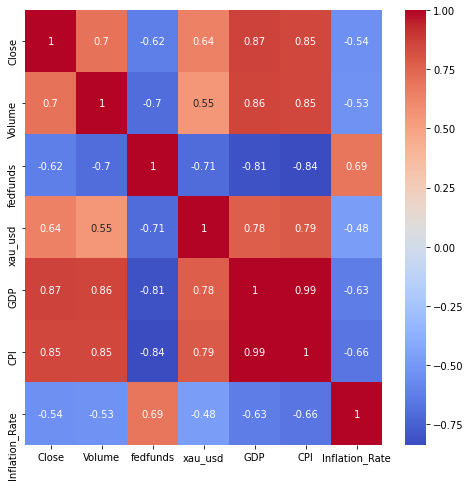

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(all_data.corr(), annot=True, cmap='coolwarm')

In [ ]:
all_data.dtypes

Date              datetime64[ns]
Close                    float64
Volume                   float64
fedfunds                 float64
xau_usd                  float64
GDP                      float64
CPI                      float64
Inflation_Rate           float64
dtype: object

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8335 entries, 0 to 8334
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            8335 non-null   datetime64[ns]
 1   Close           8335 non-null   float64       
 2   Volume          8335 non-null   float64       
 3   fedfunds        8335 non-null   float64       
 4   xau_usd         8335 non-null   float64       
 5   GDP             8335 non-null   float64       
 6   CPI             8335 non-null   float64       
 7   Inflation_Rate  8335 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 521.1 KB


In [ ]:
all_data.describe()

,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
count,8335.000000,8.335000e+03,8335.000000,8335.000000,8335.000000,8335.000000,8335.000000
mean,2010.813616,1.210974e+09,3.555211,652.369146,38026.213293,179.217193,2.623087
std,1405.762873,8.424740e+08,2.760637,433.972243,12006.196355,40.346280,1.203236
min,291.899994,4.404000e+07,0.070000,252.350000,18864.605430,108.600000,-0.355546
25%,733.609985,2.718700e+08,0.400000,352.225000,26426.627895,145.800000,1.640043
50%,1896.589966,1.474200e+09,3.770000,402.700000,37180.340188,177.700000,2.805420
75%,2645.114990,1.899490e+09,5.540000,975.870000,48479.483133,216.632000,3.376857
max,6321.759766,4.553600e+09,9.850000,1901.340000,58031.414203,244.733000,5.397956


In [ ]:
all_data.shape

(8335, 8)

In [ ]:
all_data["Date"].value_counts().shape    #kaç tane unique date var

(8335,)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8335 entries, 0 to 8334
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            8335 non-null   datetime64[ns]
 1   Close           8335 non-null   float64       
 2   Volume          8335 non-null   float64       
 3   fedfunds        8335 non-null   float64       
 4   xau_usd         8335 non-null   float64       
 5   GDP             8335 non-null   float64       
 6   CPI             8335 non-null   float64       
 7   Inflation_Rate  8335 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 521.1 KB


In [ ]:
all_data

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
0,1986-01-01,325.000000,7.581000e+07,8.14,328.90,18864.605430,109.600,1.898048
1,1986-01-02,325.000000,7.581000e+07,7.86,328.90,18864.605430,109.600,3.664563
2,1986-01-03,325.700012,8.918000e+07,7.86,330.00,18864.605430,109.600,3.664563
3,1986-01-06,326.000000,9.924000e+07,7.86,330.70,18864.605430,109.600,3.664563
4,1986-01-07,329.700012,1.275000e+08,7.86,332.80,18864.605430,109.600,3.664563
...,...,...,...,...,...,...,...,...
8330,2017-06-09,6207.919922,3.152050e+09,1.04,1267.65,58031.414203,244.733,2.130110
8331,2017-06-12,6175.459961,2.586540e+09,1.04,1266.19,58031.414203,244.733,2.130110
8332,2017-06-13,6220.370117,2.062110e+09,1.04,1266.31,58031.414203,244.733,2.130110
8333,2017-06-14,6194.890137,1.940440e+09,1.04,1261.26,58031.414203,244.733,2.130110


# Analyzes on 'Close'

## MA with Rolling Method

In [ ]:
all_data_analyze = all_data
all_data_analyze

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate
0,1986-01-01,325.000000,7.581000e+07,8.14,328.90,18864.605430,109.600,1.898048
1,1986-01-02,325.000000,7.581000e+07,7.86,328.90,18864.605430,109.600,3.664563
2,1986-01-03,325.700012,8.918000e+07,7.86,330.00,18864.605430,109.600,3.664563
3,1986-01-06,326.000000,9.924000e+07,7.86,330.70,18864.605430,109.600,3.664563
4,1986-01-07,329.700012,1.275000e+08,7.86,332.80,18864.605430,109.600,3.664563
...,...,...,...,...,...,...,...,...
8330,2017-06-09,6207.919922,3.152050e+09,1.04,1267.65,58031.414203,244.733,2.130110
8331,2017-06-12,6175.459961,2.586540e+09,1.04,1266.19,58031.414203,244.733,2.130110
8332,2017-06-13,6220.370117,2.062110e+09,1.04,1266.31,58031.414203,244.733,2.130110
8333,2017-06-14,6194.890137,1.940440e+09,1.04,1261.26,58031.414203,244.733,2.130110


In [ ]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index.Date, series)
    ax.set_title("Trend For {}".format(name))

In [ ]:
all_data_analyze['MA_10'] = all_data_analyze.Close.rolling(10).mean().shift() #calculate moving average as 10 days period for close
all_data_analyze['MA_30'] = all_data_analyze.Close.rolling(30).mean().shift() #calculate moving average as 30 days period for close

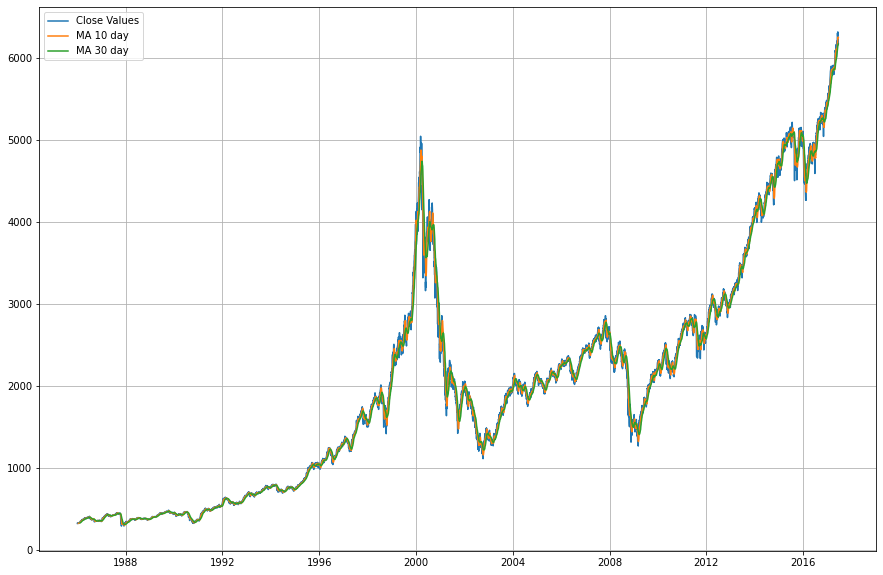

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(all_data_analyze['Date'], all_data_analyze['Close'],label='Close Values')
plt.plot(all_data_analyze['Date'], all_data_analyze['MA_10'], label='MA 10 day')
plt.plot(all_data_analyze['Date'], all_data_analyze['MA_30'], label='MA 30 day')
plt.legend(loc=2)

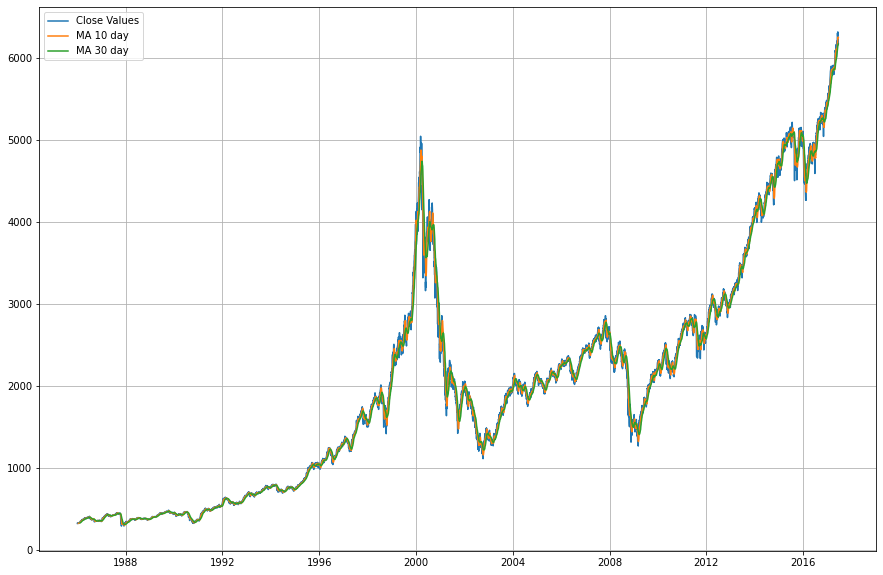

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(all_data_analyze['Date'], all_data_analyze['Close'],label='Close Values')
plt.plot(all_data_analyze['Date'], all_data_analyze['MA_10'], label='MA 10 day')
plt.plot(all_data_analyze['Date'], all_data_analyze['MA_30'], label='MA 30 day')
plt.legend(loc=2)

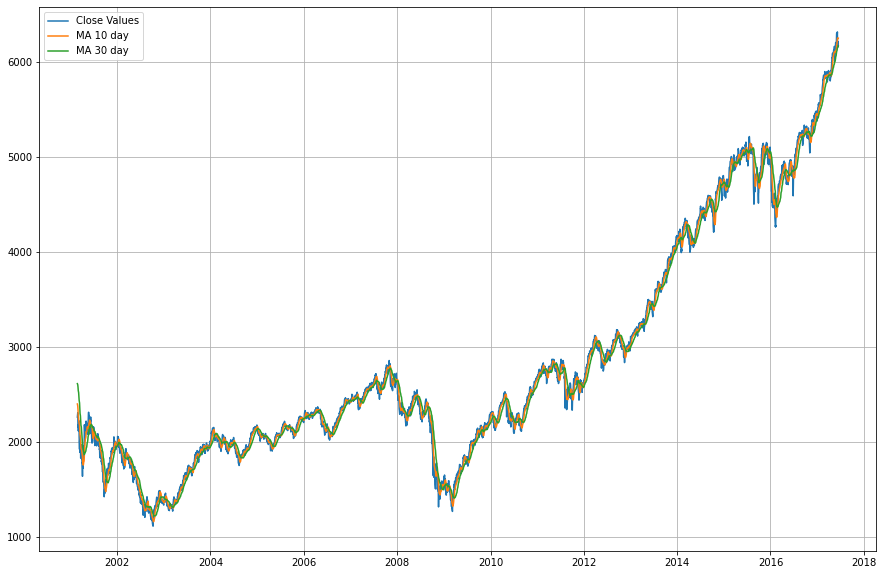

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(all_data_analyze['Date'][4000:], all_data_analyze['Close'][4000:],label='Close Values')
plt.plot(all_data_analyze['Date'][4000:], all_data_analyze['MA_10'][4000:], label='MA 10 day')
plt.plot(all_data_analyze['Date'][4000:], all_data_analyze['MA_30'][4000:], label='MA 30 day')
plt.legend(loc=2)

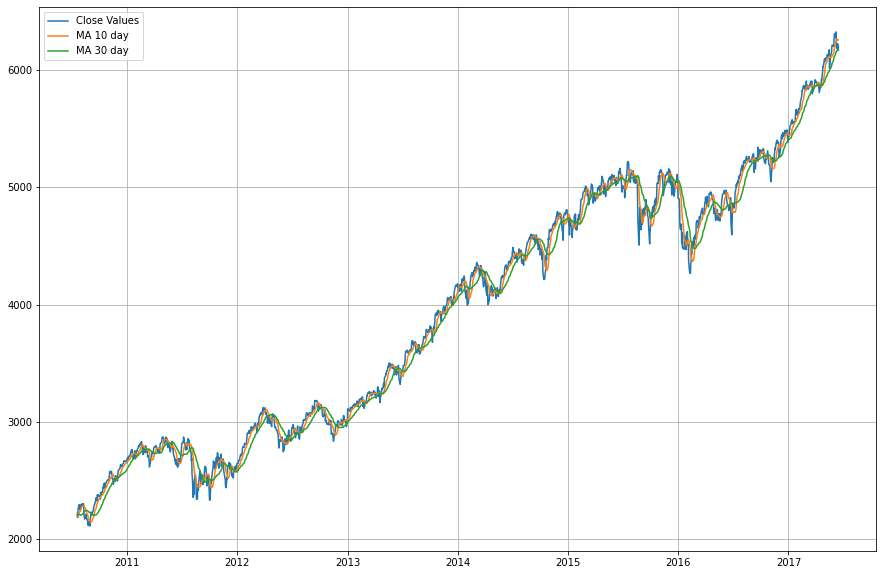

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(all_data_analyze['Date'][6500:], all_data_analyze['Close'][6500:],label='Close Values')
plt.plot(all_data_analyze['Date'][6500:], all_data_analyze['MA_10'][6500:], label='MA 10 day')
plt.plot(all_data_analyze['Date'][6500:], all_data_analyze['MA_30'][6500:], label='MA 30 day')
plt.legend(loc=2)

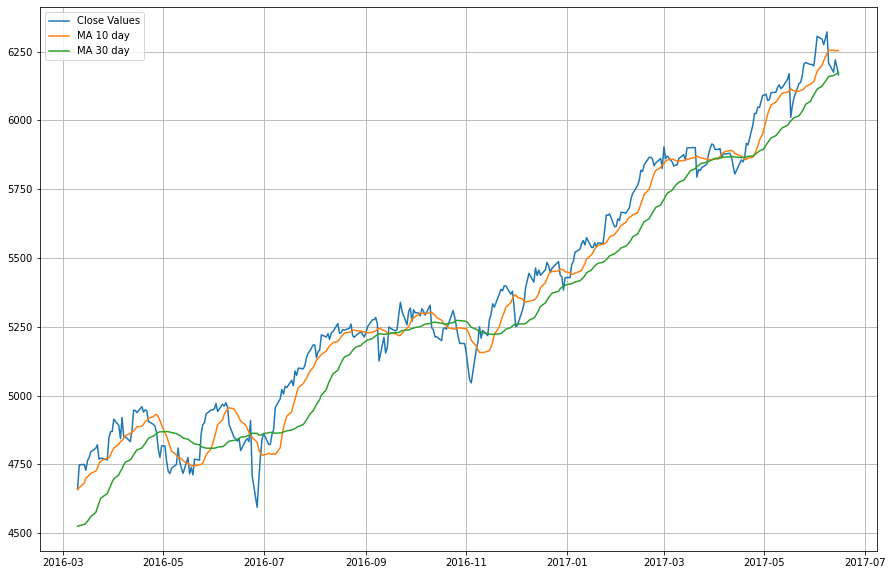

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(all_data_analyze['Date'][8000:], all_data_analyze['Close'][8000:],label='Close Values')
plt.plot(all_data_analyze['Date'][8000:], all_data_analyze['MA_10'][8000:], label='MA 10 day')
plt.plot(all_data_analyze['Date'][8000:], all_data_analyze['MA_30'][8000:], label='MA 30 day')
plt.legend(loc=2)

## Additive Decomposition and Checking Stationary

In [ ]:
#yıllık, aylık ve haftalık olarak çoğalt!!

In [ ]:
all_data_analyze

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate,MA_10,MA_30
0,1986-01-01,325.000000,7.581000e+07,8.14,328.90,18864.605430,109.600,1.898048,NaN,NaN
1,1986-01-02,325.000000,7.581000e+07,7.86,328.90,18864.605430,109.600,3.664563,NaN,NaN
2,1986-01-03,325.700012,8.918000e+07,7.86,330.00,18864.605430,109.600,3.664563,NaN,NaN
3,1986-01-06,326.000000,9.924000e+07,7.86,330.70,18864.605430,109.600,3.664563,NaN,NaN
4,1986-01-07,329.700012,1.275000e+08,7.86,332.80,18864.605430,109.600,3.664563,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
8330,2017-06-09,6207.919922,3.152050e+09,1.04,1267.65,58031.414203,244.733,2.130110,6255.759961,6159.487321
8331,2017-06-12,6175.459961,2.586540e+09,1.04,1266.19,58031.414203,244.733,2.130110,6255.532959,6163.364649
8332,2017-06-13,6220.370117,2.062110e+09,1.04,1266.31,58031.414203,244.733,2.130110,6252.759961,6166.159977
8333,2017-06-14,6194.890137,1.940440e+09,1.04,1261.26,58031.414203,244.733,2.130110,6254.477979,6170.326644


In [ ]:
components = tsa.seasonal_decompose(all_data_analyze.Close, freq=31*12) # 12*31 because 12 months for every 31 year

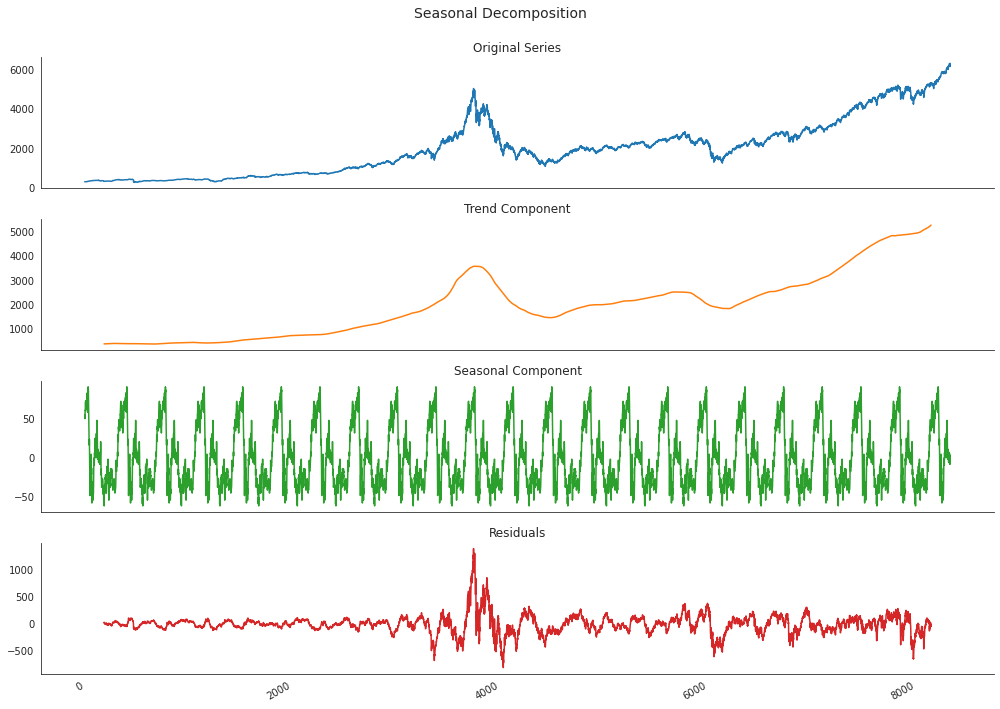

In [ ]:
# additive
# hatali

ts = (all_data_analyze.Close.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 10), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

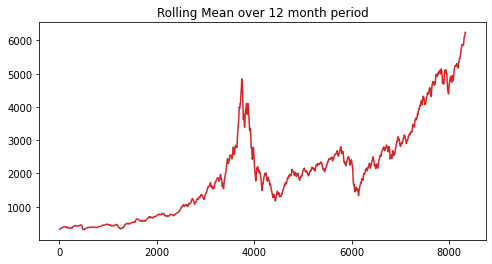

In [ ]:
all_data_analyze.Close.rolling(window = 12).mean().plot(figsize=(8,4), color="tab:red", title="Rolling Mean over 12 month period");


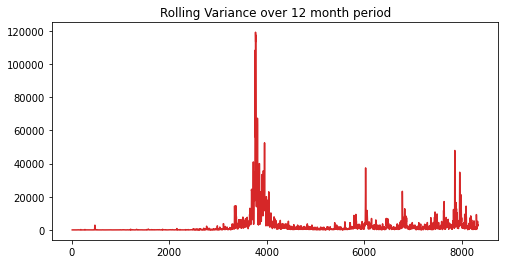

In [ ]:
all_data_analyze.Close.rolling(window = 12).var().plot(figsize=(8,4), color="tab:red", title="Rolling Variance over 12 month period");


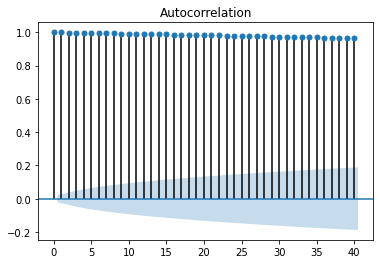

In [ ]:
# plotting auto-correlation plot
# whether time-series are positively correlated, negatively correlated or not related at all with past values
# Result: Values are positively correlated with past

from statsmodels.graphics.tsaplots import plot_acf
#lag artır

plot_acf(all_data_analyze.Close);


In [ ]:
# dicky-fuller test for checking the stationary

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(all_data_analyze['Close'], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  0.6320853079210084
2. P-Value :  0.98838034801454
3. Num Of Lags :  35
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 8299
5. Critical Values :
	 1% :  -3.4311382062666165
	 5% :  -2.8618883324211724
	 10% :  -2.56695541251651


p-value > 0.05 - This implies that time-series is non-stationary.

p-value <=0.05 - This implies that time-series is stationary.

because of **p-value is greater than 0.05**, time-series is **not stationary**.

## Volatility

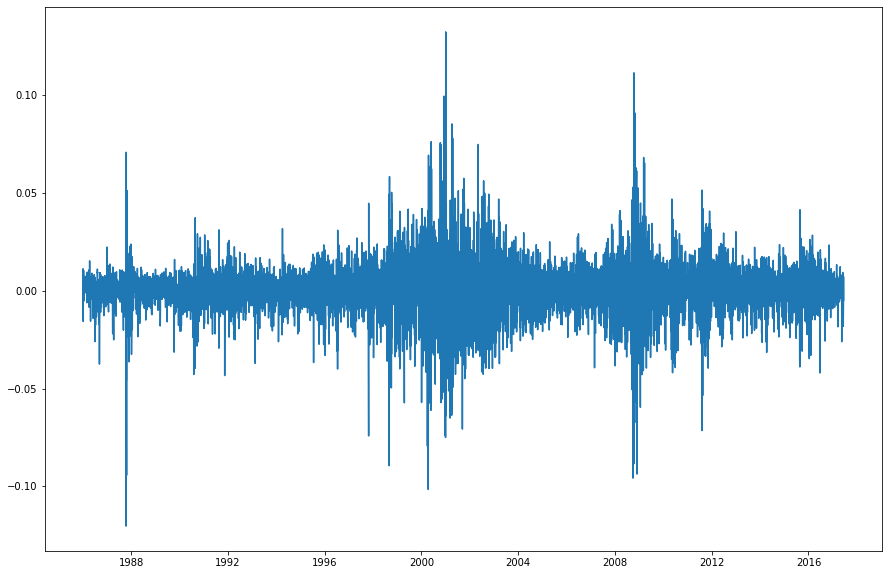

In [ ]:
plt.figure(figsize=(15,10))
all_data_analyze["Volatility"] = np.log(all_data_analyze["Close"] / all_data_analyze["Close"].shift())
plt.plot(all_data_analyze.Date, all_data_analyze.Volatility)

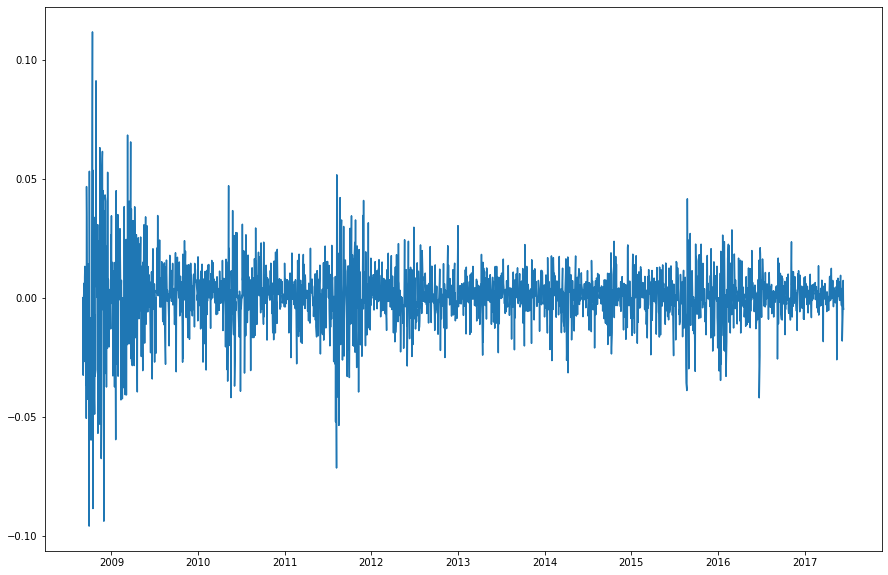

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(all_data_analyze['Date'][6000:], all_data_analyze.Volatility[6000:])

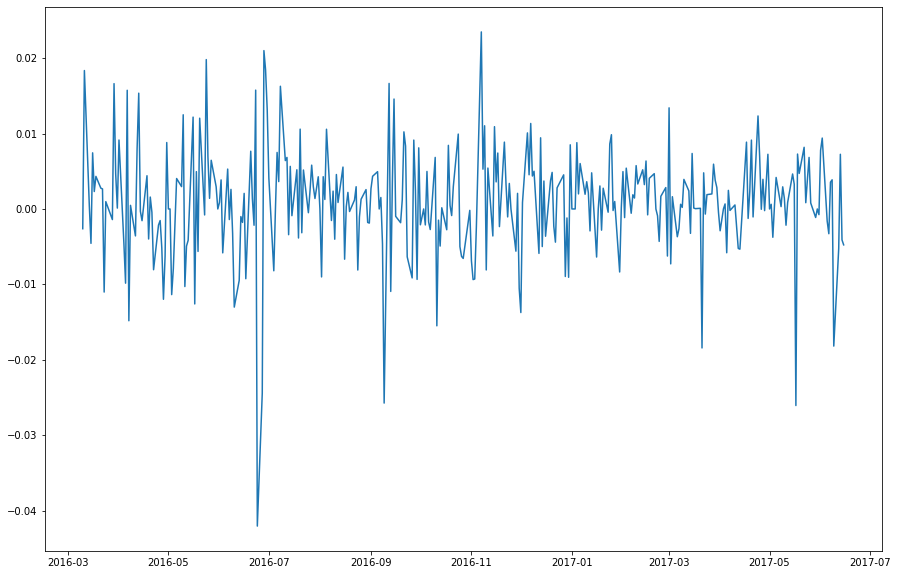

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(all_data_analyze['Date'][8000:], all_data_analyze.Volatility[8000:])

# Univariate LSTM for 'Close'


## Data Manipulation for "Close"

In [ ]:
all_data

,Date,Close,Volume,fedfunds,xau_usd,GDP,CPI,Inflation_Rate,MA_10,MA_30,Volatility
0,1986-01-01,325.000000,7.581000e+07,8.14,328.90,18864.605430,109.600,1.898048,NaN,NaN,NaN
1,1986-01-02,325.000000,7.581000e+07,7.86,328.90,18864.605430,109.600,3.664563,NaN,NaN,0.000000
2,1986-01-03,325.700012,8.918000e+07,7.86,330.00,18864.605430,109.600,3.664563,NaN,NaN,0.002152
3,1986-01-06,326.000000,9.924000e+07,7.86,330.70,18864.605430,109.600,3.664563,NaN,NaN,0.000921
4,1986-01-07,329.700012,1.275000e+08,7.86,332.80,18864.605430,109.600,3.664563,NaN,NaN,0.011286
...,...,...,...,...,...,...,...,...,...,...,...
8330,2017-06-09,6207.919922,3.152050e+09,1.04,1267.65,58031.414203,244.733,2.130110,6255.759961,6159.487321,-0.018172
8331,2017-06-12,6175.459961,2.586540e+09,1.04,1266.19,58031.414203,244.733,2.130110,6255.532959,6163.364649,-0.005243
8332,2017-06-13,6220.370117,2.062110e+09,1.04,1266.31,58031.414203,244.733,2.130110,6252.759961,6166.159977,0.007246
8333,2017-06-14,6194.890137,1.940440e+09,1.04,1261.26,58031.414203,244.733,2.130110,6254.477979,6170.326644,-0.004105


In [ ]:
uni_data = all_data.drop(["Volume", "fedfunds",	"xau_usd", "GDP",	"CPI",	"Inflation_Rate"], axis = 1)
uni_data = uni_data[uni_data["Date"] < "2017-06-15"] 
#uni_data = uni_data[uni_data["Date"] > "2000-06-15"] 
uni_data.reset_index()

,index,Date,Close,MA_10,MA_30,Volatility
0,0,1986-01-01,325.000000,NaN,NaN,NaN
1,1,1986-01-02,325.000000,NaN,NaN,0.000000
2,2,1986-01-03,325.700012,NaN,NaN,0.002152
3,3,1986-01-06,326.000000,NaN,NaN,0.000921
4,4,1986-01-07,329.700012,NaN,NaN,0.011286
...,...,...,...,...,...,...
8329,8329,2017-06-08,6321.759766,6244.109961,6150.348991,0.003864
8330,8330,2017-06-09,6207.919922,6255.759961,6159.487321,-0.018172
8331,8331,2017-06-12,6175.459961,6255.532959,6163.364649,-0.005243
8332,8332,2017-06-13,6220.370117,6252.759961,6166.159977,0.007246


In [ ]:
uni_data

,Date,Close,MA_10,MA_30,Volatility
0,1986-01-01,325.000000,NaN,NaN,NaN
1,1986-01-02,325.000000,NaN,NaN,0.000000
2,1986-01-03,325.700012,NaN,NaN,0.002152
3,1986-01-06,326.000000,NaN,NaN,0.000921
4,1986-01-07,329.700012,NaN,NaN,0.011286
...,...,...,...,...,...
8329,2017-06-08,6321.759766,6244.109961,6150.348991,0.003864
8330,2017-06-09,6207.919922,6255.759961,6159.487321,-0.018172
8331,2017-06-12,6175.459961,6255.532959,6163.364649,-0.005243
8332,2017-06-13,6220.370117,6252.759961,6166.159977,0.007246


In [ ]:
uni_data_dates = uni_data['Date']

In [ ]:
uni_data_close = uni_data.reset_index()["Close"]

In [ ]:
uni_data_close.shape

(8334,)

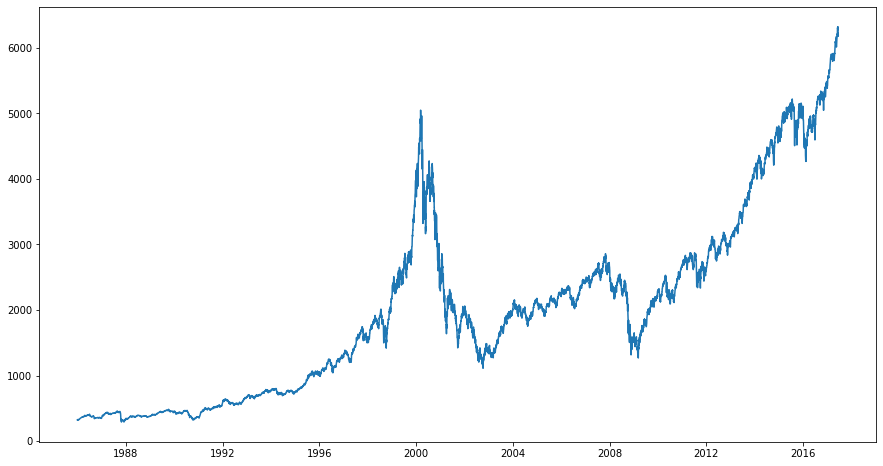

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(uni_data_dates, uni_data_close)

In [ ]:
uni_data_close

0        325.000000
1        325.000000
2        325.700012
3        326.000000
4        329.700012
           ...     
8329    6321.759766
8330    6207.919922
8331    6175.459961
8332    6220.370117
8333    6194.890137
Name: Close, Length: 8334, dtype: float64

In [ ]:
#reshape onemli cunku uni_data_close'u array haline getiriyor 
scaler = MinMaxScaler(feature_range=(0,1))
uni_data_close = scaler.fit_transform(np.array(uni_data_close).reshape(-1,1))


In [ ]:
uni_data_close

array([[0.00548935],
       [0.00548935],
       [0.00560544],
       ...,
       [0.97573744],
       [0.98318541],
       [0.97895977]])

In [ ]:
## Train and Test split
training_size = int(len(uni_data_close)*0.90)
test_size = len(uni_data_close) - training_size
train_data = uni_data_close[0:training_size,:]
test_data = uni_data_close[training_size:len(uni_data_close),:1]

In [ ]:
training_size, test_size

(7500, 834)

In [ ]:
len(train_data), len(test_data)

(7500, 834)

In [ ]:
#train_data

In [ ]:
#test_data

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
import numpy
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
time_step

10

In [ ]:
print(X_train.shape), print(y_train.shape)

(7489, 10)
(7489,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(823, 10)
(823,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
print(X_test.shape), print(ytest.shape)

(823, 10, 1)
(823,)


(None, None)

## Hyperparameter Tuning for Learning Rate

In [ ]:
# with Keras-Tuner library

In [ ]:
def build_model(hp):
    model=Sequential()
    model.add(LSTM(64,activation="tanh",return_sequences=True,input_shape=(time_step,1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64,activation="tanh",return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,activation="tanh",return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,activation="tanh", return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    lr = hp.Float('learning_rate', 1e-4, 1e-3, sampling='log', default=1e-3)
    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr),
        #optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005, 0.00001, 0.00005])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir_v11',
    project_name='helloworld')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              mode='min', 
                              verbose=1,
                              restore_best_weights=True)

In [ ]:
tuner.search(X_train, y_train,
             epochs=50,
             batch_size = 250,
             shuffle=False,
             callbacks=[early_stopping],
             validation_data=(X_test, ytest))

Trial 20 Complete [00h 03m 26s]
val_loss: 0.0005031134351156652

Best val_loss So Far: 0.00032982031310287613
Total elapsed time: 01h 08m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir_v11/helloworld
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.00020458634068005996
Score: 0.00032982031310287613
Trial summary
Hyperparameters:
learning_rate: 0.0003772133520930692
Score: 0.00033400653046555817
Trial summary
Hyperparameters:
learning_rate: 0.00021612657056743233
Score: 0.0003431302514703323
Trial summary
Hyperparameters:
learning_rate: 0.0004861831180680034
Score: 0.0003620795323513448
Trial summary
Hyperparameters:
learning_rate: 0.00019579967835120355
Score: 0.00036785535242718953
Trial summary
Hyperparameters:
learning_rate: 0.00023757064463260523
Score: 0.00036841267137788236
Trial summary
Hyperparameters:
learning_rate: 0.0005193590074039599
Score: 0.00040093848171333474
Trial summary
Hyperparameters:
learning_rate: 0.0006205859578044008
Score: 0.0004265837390751888
Trial summary
Hyperparameters:
learning_rate: 0.00010033049535497913
Score: 0.0004951806622557342
T

## Hyperparameter Tuning for Dropout

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00020458634068005996, # from hyperparameter optimization for LR
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,""
    name="Adam",
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              mode='min', 
                              verbose=1,
                              restore_best_weights=True)

In [ ]:
drops = [0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
  for drop in drops:
    ### Create the Stacked LSTM model
    print(drop)
    model=Sequential()
    model.add(LSTM(64,activation="tanh",return_sequences=True,input_shape=(time_step,1)))
    model.add(Dropout(drop))
    model.add(LSTM(64,activation="tanh",return_sequences=True))
    model.add(Dropout(drop))
    model.add(LSTM(64,activation="tanh",return_sequences=True))
    model.add(Dropout(drop))
    model.add(LSTM(64,activation="tanh", return_sequences=False))
    model.add(Dropout(drop))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer, 
            metrics=['mean_squared_error'])
    model.summary()

    for i in range (1,6,1):
      print(i)

      history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_test,ytest), 
                        epochs=50, 
                        batch_size=250, 
                        shuffle=False,
                        callbacks=[early_stopping],
                        verbose=1) 
      ### prediction
      train_predict=model.predict(X_train)
      test_predict=model.predict(X_test)

      # rescaled of predictions
      train_predict=scaler.inverse_transform(train_predict)
      test_predict=scaler.inverse_transform(test_predict)

      # rescaled for train and test error graphs
      y_train = y_train.reshape(-1,1)
      ytest = ytest.reshape(-1,1)

      y_train_rescaled=scaler.inverse_transform(y_train).squeeze()
      ytest_rescaled=scaler.inverse_transform(ytest).squeeze()


      # Calculation of MSE
      train_mse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train),train_predict))
      test_mse = math.sqrt(mean_squared_error(scaler.inverse_transform(ytest),test_predict))
      print(f'Train MSE: {train_mse:.2f} | Test MSE: {test_mse:.2f}')

0.1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
module_wrapper_24 (ModuleWra (None, 10, 64)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 10, 64)            33024     
_________________________________________________________________
module_wrapper_25 (ModuleWra (None, 10, 64)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 10, 64)            33024     
_________________________________________________________________
module_wrapper_26 (ModuleWra (None, 10, 64)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 64)           

## Hyperparameter Tuning for Batch Size


In [ ]:
for ep in range (250, 450, 15):
  history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test,ytest), 
                    epochs=50, 
                    batch_size=ep, 
                    shuffle=False,
                    callbacks=[early_stopping],
                    verbose=1) 
  ### prediction
  train_predict=model.predict(X_train)
  test_predict=model.predict(X_test)

  # rescaled of predictions
  train_predict=scaler.inverse_transform(train_predict)
  test_predict=scaler.inverse_transform(test_predict)

  # rescaled for train and test error graphs
  y_train = y_train.reshape(-1,1)
  ytest = ytest.reshape(-1,1)

  y_train_rescaled=scaler.inverse_transform(y_train).squeeze()
  ytest_rescaled=scaler.inverse_transform(ytest).squeeze()


  # Calculation of MSE
  train_mse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train),train_predict))
  test_mse = math.sqrt(mean_squared_error(scaler.inverse_transform(ytest),test_predict))
  print(f'Train MSE: {train_mse:.2f} | Test MSE: {test_mse:.2f}')

Epoch 1/50
30/30 [==============================] - 11s 168ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.2311 - val_mean_squared_error: 0.2311
Epoch 2/50
30/30 [==============================] - 4s 118ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0676 - val_mean_squared_error: 0.0676
Epoch 3/50
30/30 [==============================] - 3s 116ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 4/50
30/30 [==============================] - 4s 118ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 8.0865e-04 - val_mean_squared_error: 8.0865e-04
Epoch 5/50
30/30 [==============================] - 4s 119ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 6/50
30/30 [==============================] - 3s 116ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 7/50
30/30 [=

In [ ]:
best_batch_size = 250

## LSTM Model

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00020458634068005996, # from hyperparameter optimization for LR
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

In [ ]:
### Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(64,activation="tanh",return_sequences=True,input_shape=(time_step,1)))
model.add(Dropout(0.2))
model.add(LSTM(64,activation="tanh",return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation="tanh",return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation="tanh", return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer, 
              metrics=['mean_squared_error'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
module_wrapper_44 (ModuleWra (None, 10, 64)            0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 10, 64)            33024     
_________________________________________________________________
module_wrapper_45 (ModuleWra (None, 10, 64)            0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 10, 64)            33024     
_________________________________________________________________
module_wrapper_46 (ModuleWra (None, 10, 64)            0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 64)              

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              mode='min', 
                              verbose=1,
                              restore_best_weights=True)

## Model Test

Epoch 1/50
30/30 [==============================] - 12s 193ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.1377 - val_mean_squared_error: 0.1377
Epoch 2/50
30/30 [==============================] - 4s 120ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0533 - val_mean_squared_error: 0.0533
Epoch 3/50
30/30 [==============================] - 4s 120ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 4/50
30/30 [==============================] - 4s 121ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/50
30/30 [==============================] - 4s 122ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 6/50
30/30 [==============================] - 4s 119ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 8.0155e-04 - val_mean_squared_error: 8.0155e-04
Epoch 7/50
30/30 [=

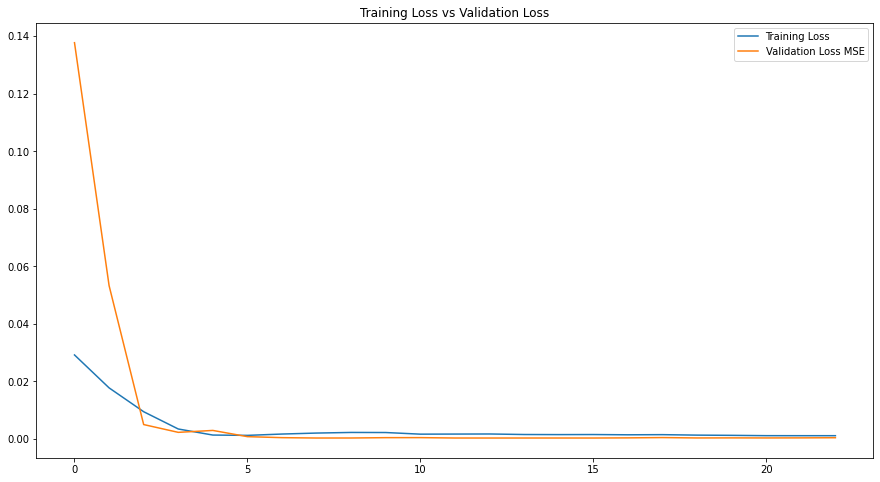

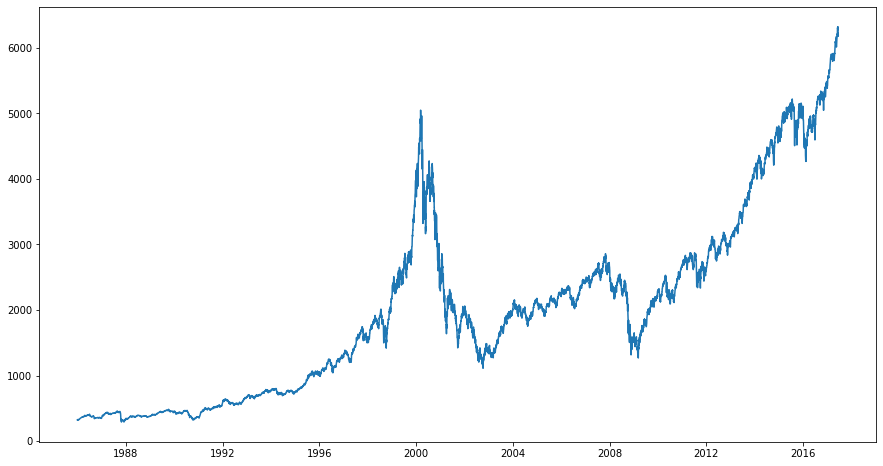

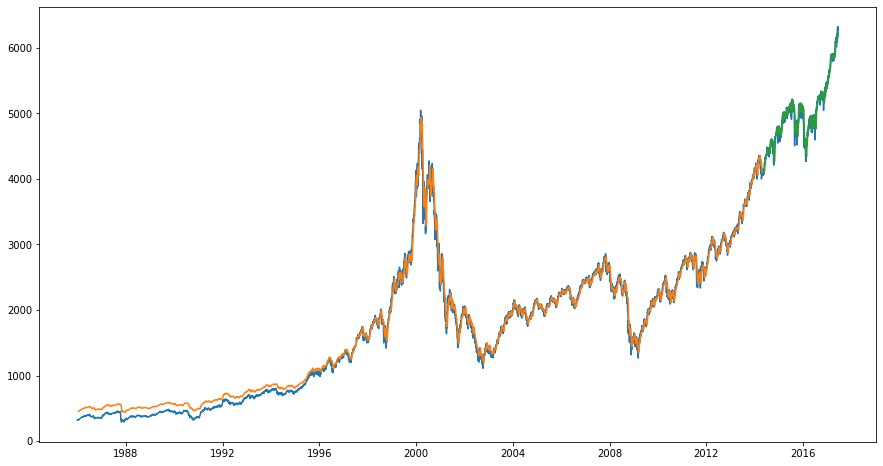

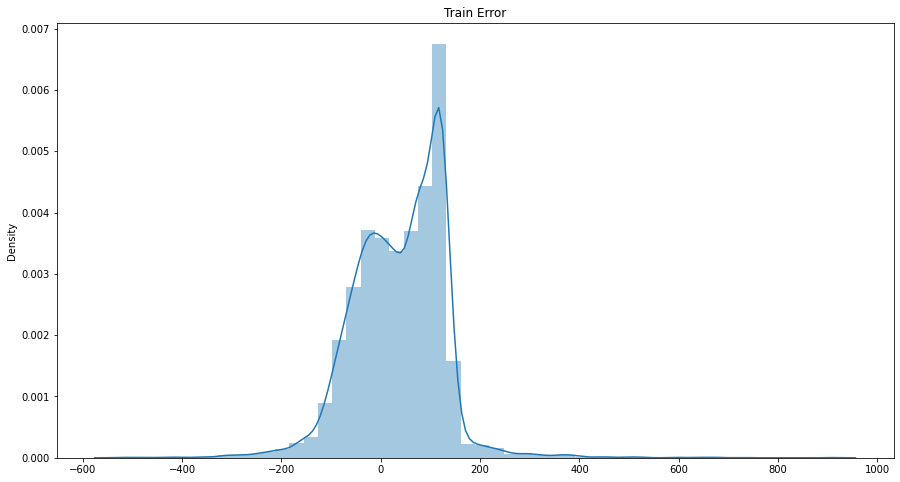

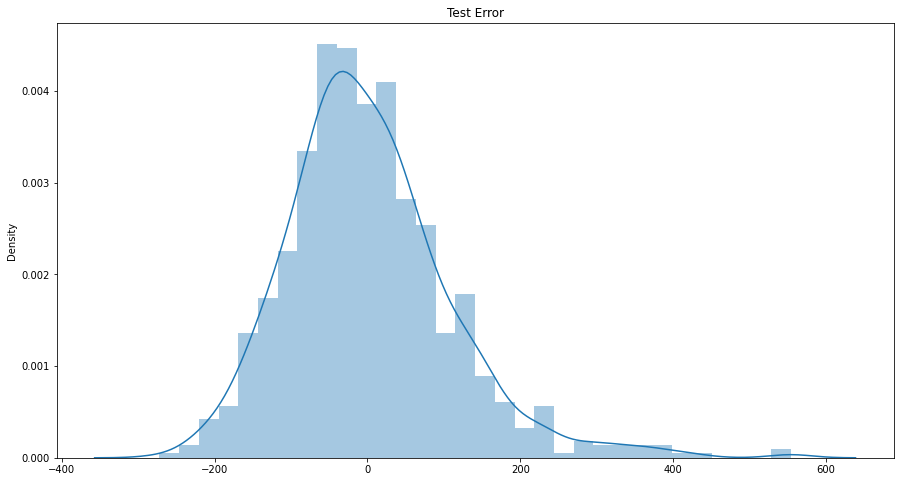

10
mse_of_pred: 62.69 | rmse_of_pred: 7.92
Epoch 1/50
30/30 [==============================] - 9s 173ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 4.2610e-04 - val_mean_squared_error: 4.2610e-04
Epoch 2/50
30/30 [==============================] - 4s 124ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.9441e-04 - val_mean_squared_error: 7.9441e-04
Epoch 3/50
30/30 [==============================] - 4s 126ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.9494e-04 - val_mean_squared_error: 5.9494e-04
Epoch 4/50
30/30 [==============================] - 4s 123ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.6145e-04 - val_mean_squared_error: 7.6145e-04
Epoch 5/50
30/30 [==============================] - 4s 124ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 6.4356e-04 - val_mean_squared_error: 6.4356e-04
Epoch 6/50
30/30 [==============================] - 4s 122ms/step - loss: 0.0013 - mean_squared_error: 0.00

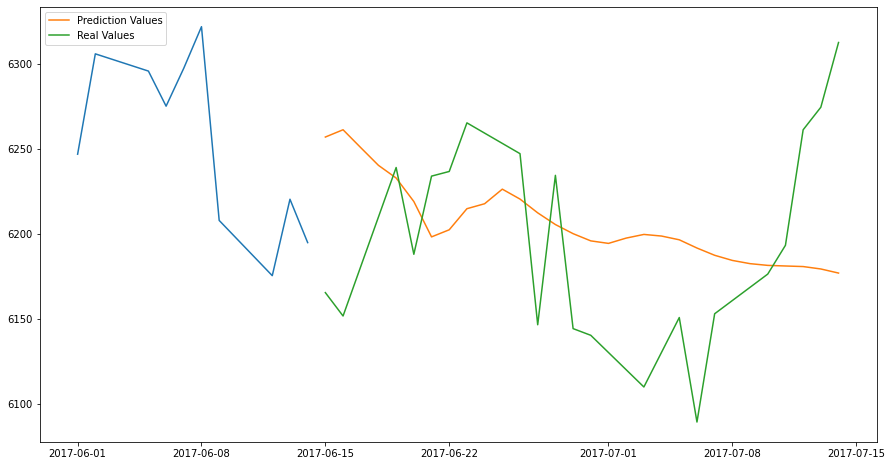

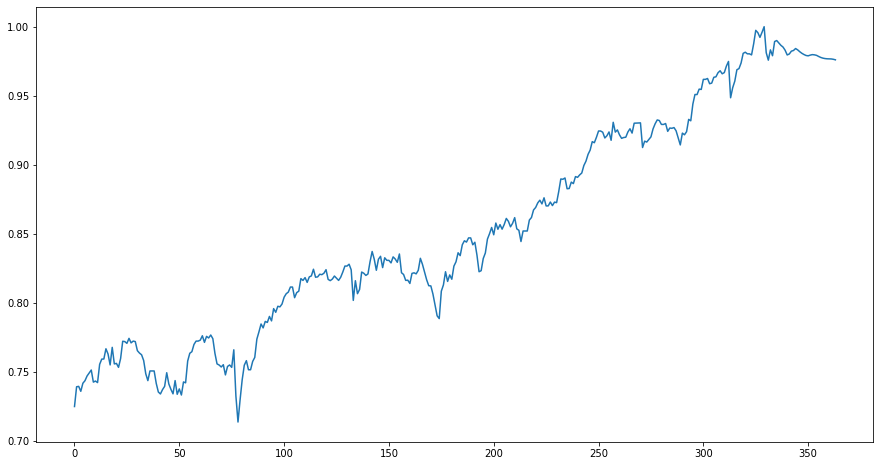

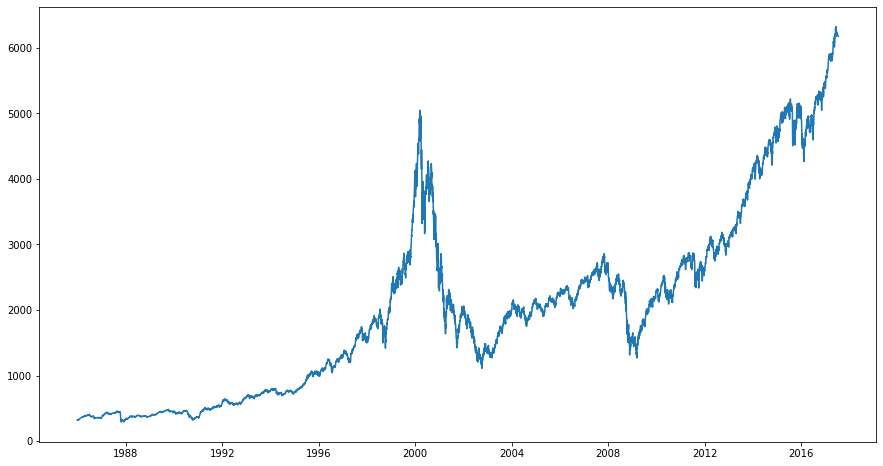

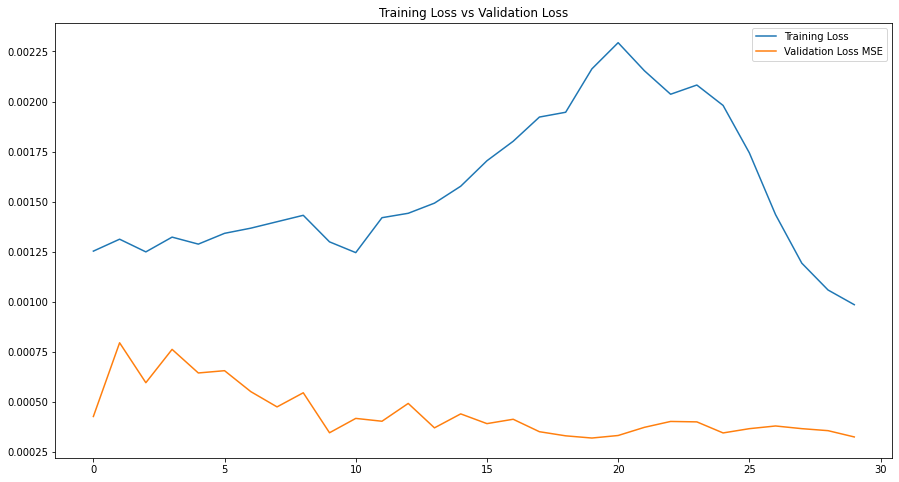

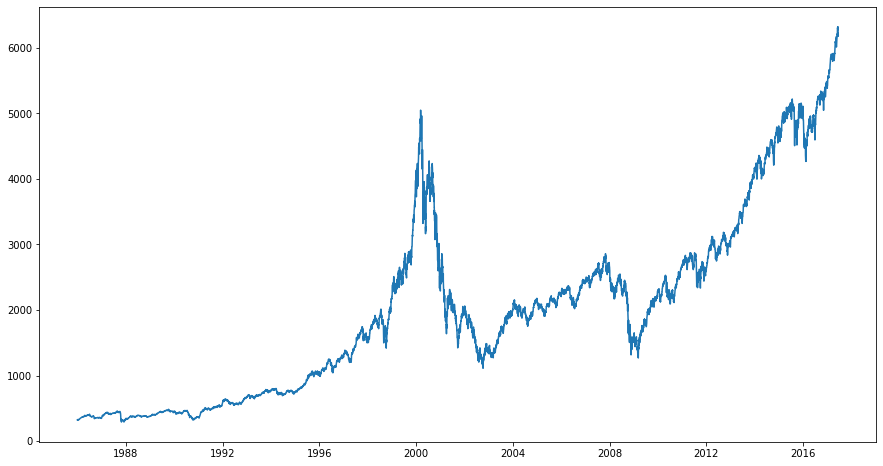

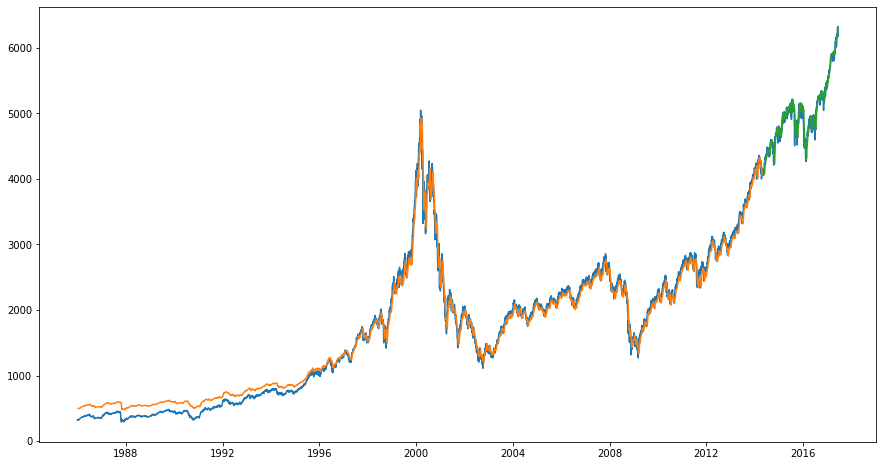

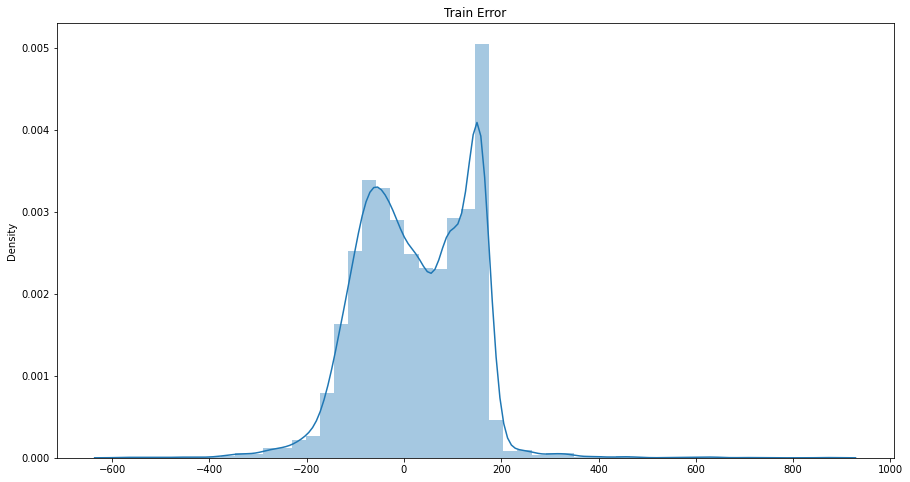

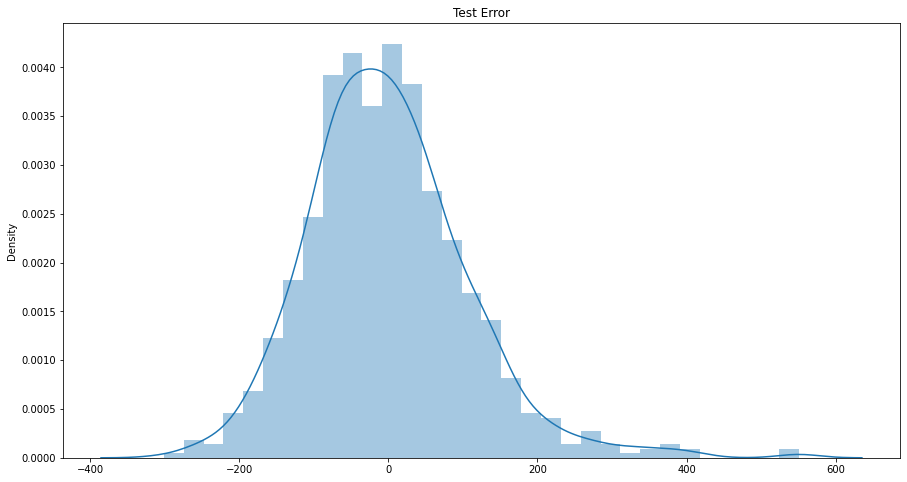

10
mse_of_pred: 216.05 | rmse_of_pred: 14.70
Epoch 1/50
30/30 [==============================] - 4s 128ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 5.0392e-04 - val_mean_squared_error: 5.0392e-04
Epoch 2/50
30/30 [==============================] - 4s 127ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 3.2987e-04 - val_mean_squared_error: 3.2987e-04
Epoch 3/50
30/30 [==============================] - 4s 127ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 3.3479e-04 - val_mean_squared_error: 3.3479e-04
Epoch 4/50
30/30 [==============================] - 4s 126ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 3.1834e-04 - val_mean_squared_error: 3.1834e-04
Epoch 5/50
30/30 [==============================] - 4s 125ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 3.1106e-04 - val_mean_squared_error: 3.1106e-04
Epoch 6/50
30/30 [==============================] - 4s 126ms/step - loss: 0.0020 - mean_squared_error: 0.

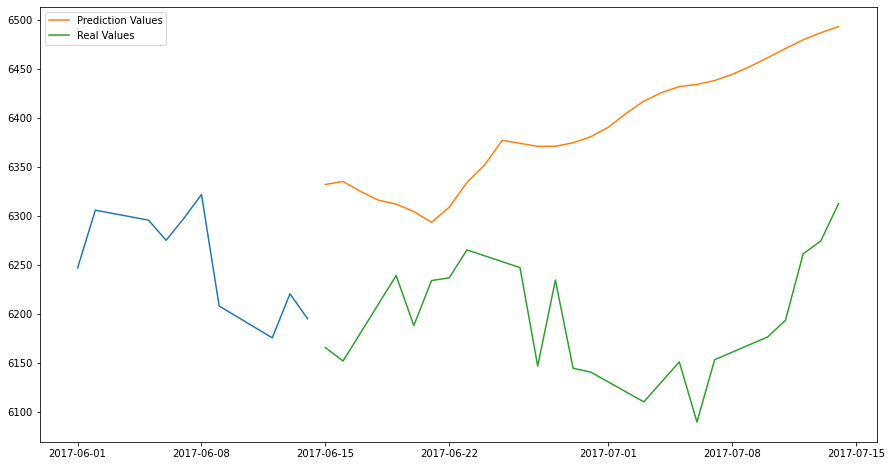

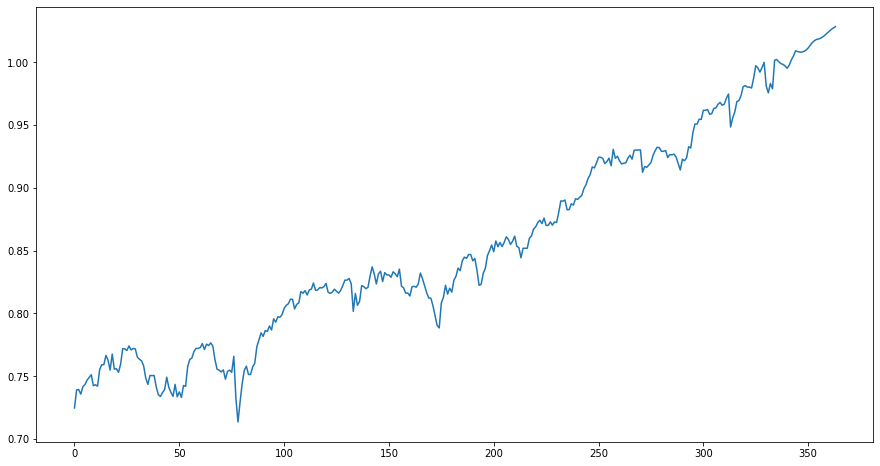

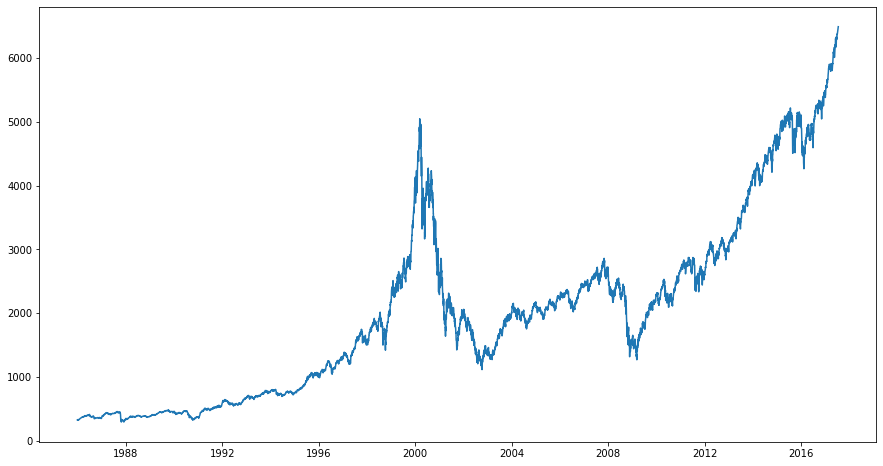

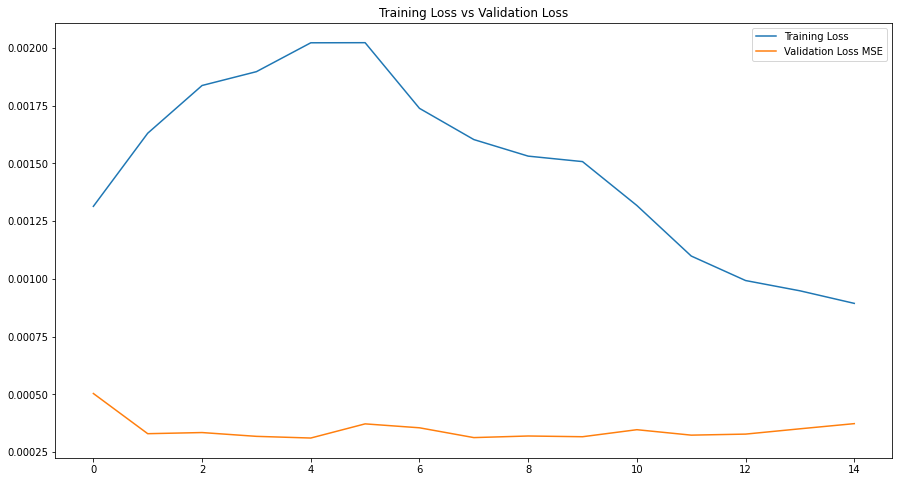

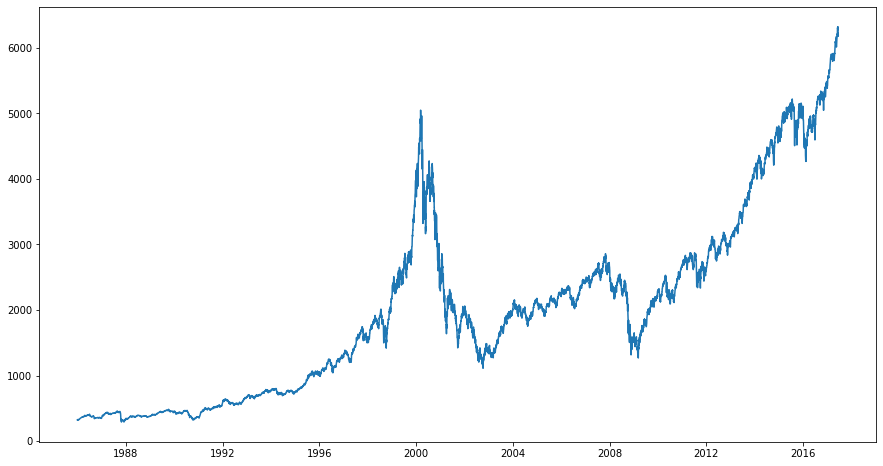

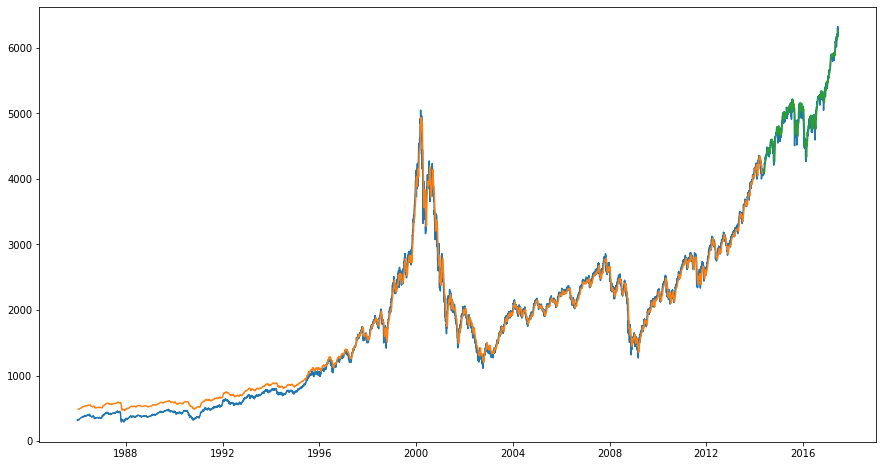

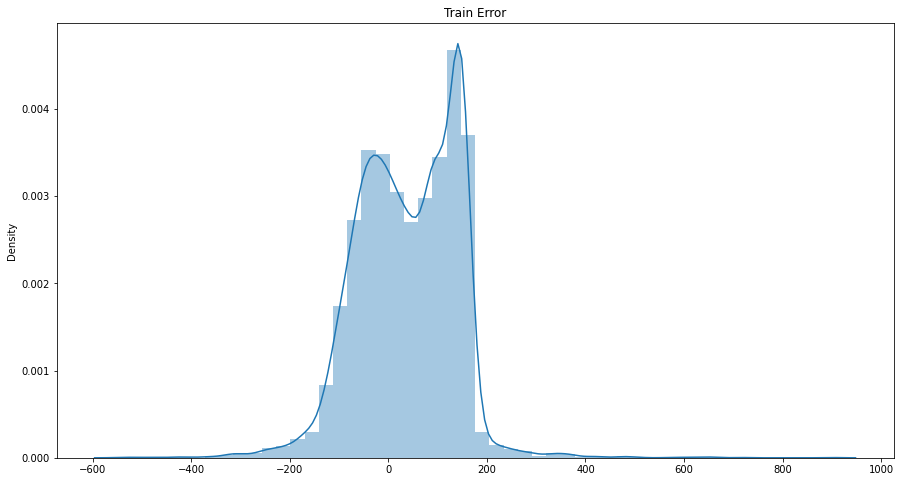

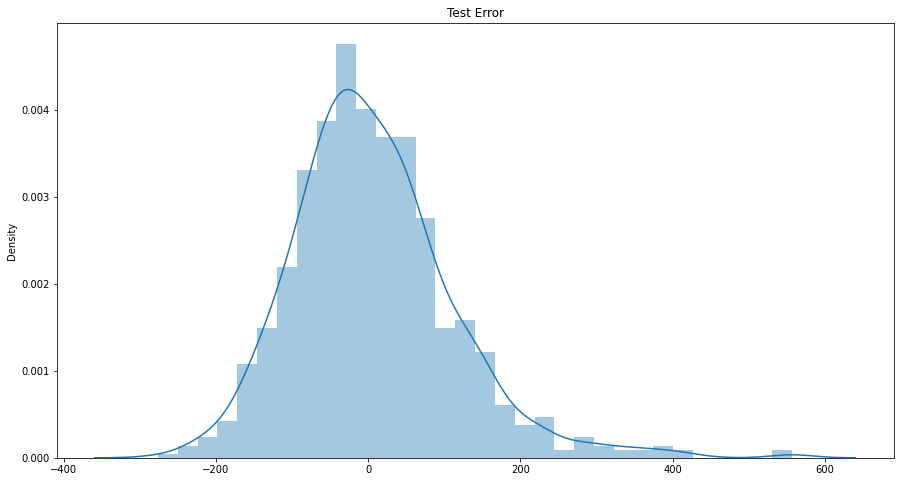

10
mse_of_pred: 117.34 | rmse_of_pred: 10.83
Epoch 1/50
30/30 [==============================] - 4s 133ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 4.2056e-04 - val_mean_squared_error: 4.2056e-04
Epoch 2/50
30/30 [==============================] - 4s 130ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.4244e-04 - val_mean_squared_error: 3.4244e-04
Epoch 3/50
30/30 [==============================] - 4s 132ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.1213e-04 - val_mean_squared_error: 3.1213e-04
Epoch 4/50
30/30 [==============================] - 4s 132ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.4855e-04 - val_mean_squared_error: 3.4855e-04
Epoch 5/50
30/30 [==============================] - 4s 132ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 3.3158e-04 - val_mean_squared_error: 3.3158e-04
Epoch 6/50
30/30 [==============================] - 4s 131ms/step - loss: 0.0015 - mean_squared_error: 0.

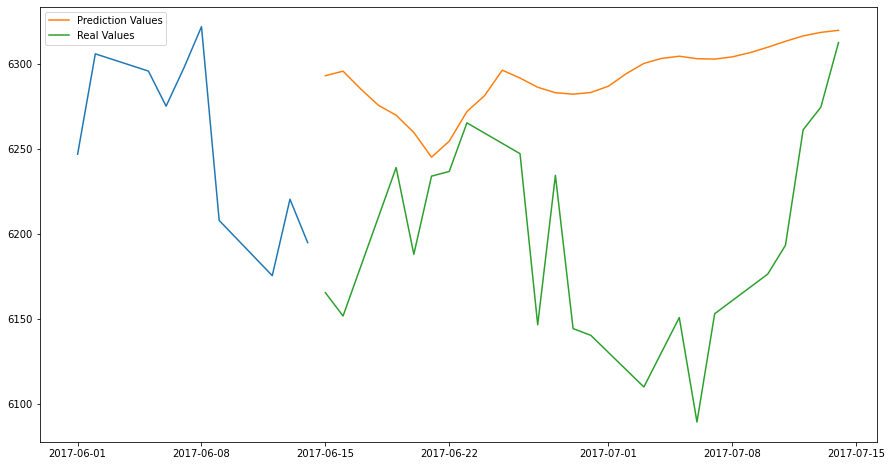

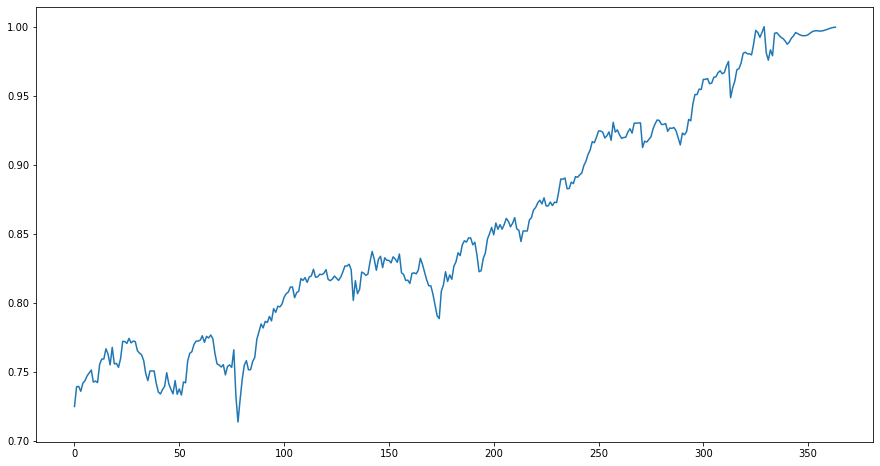

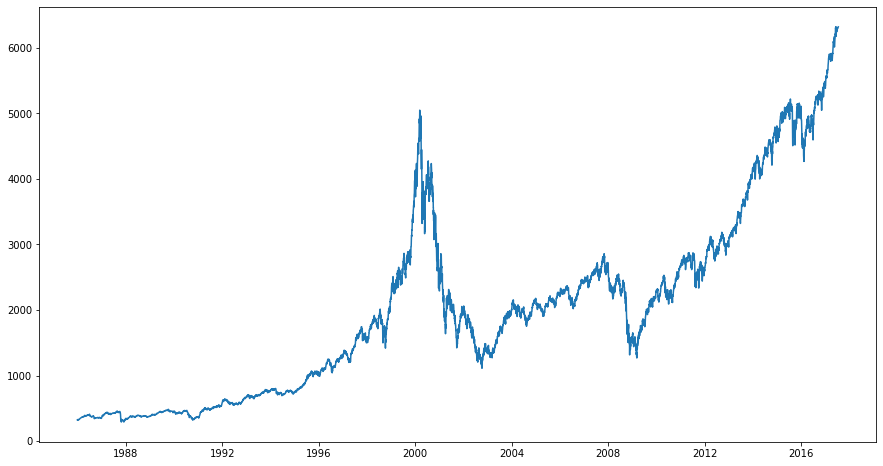

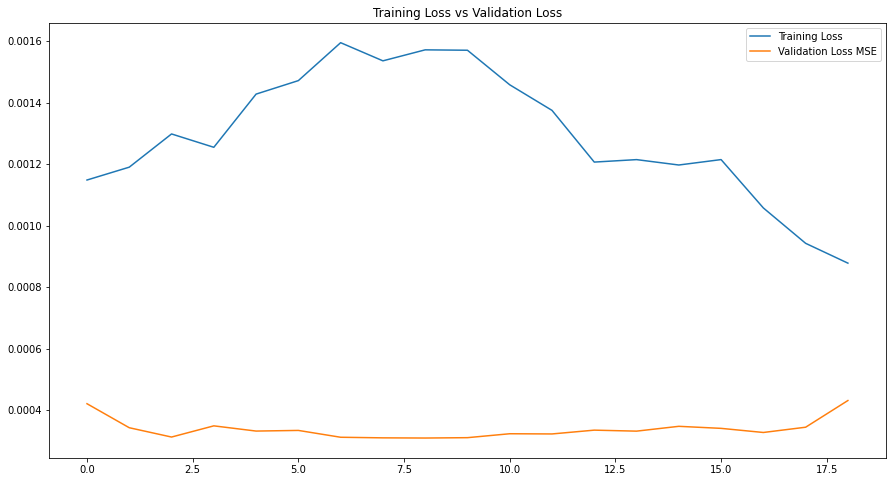

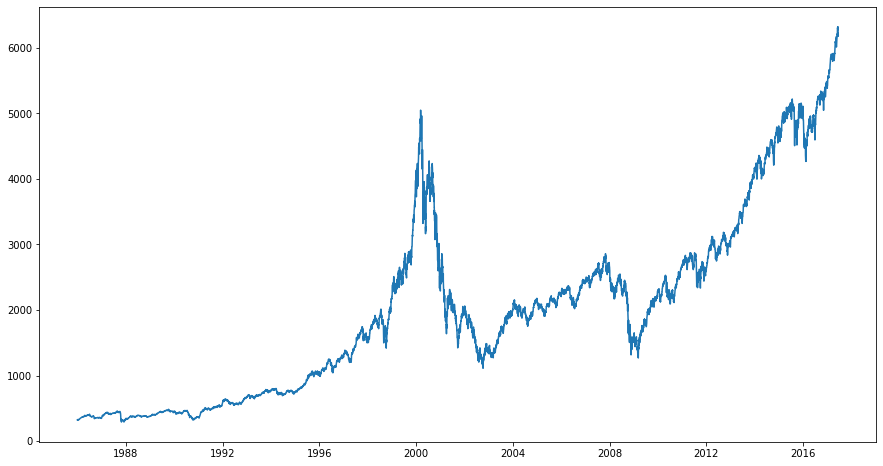

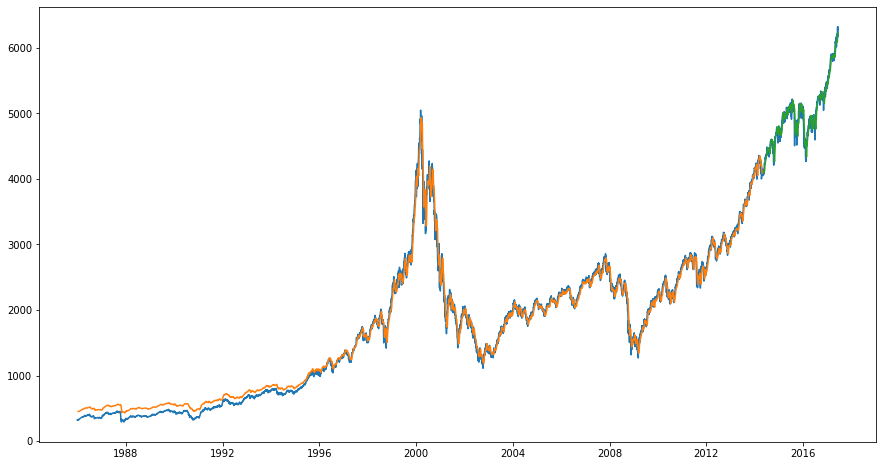

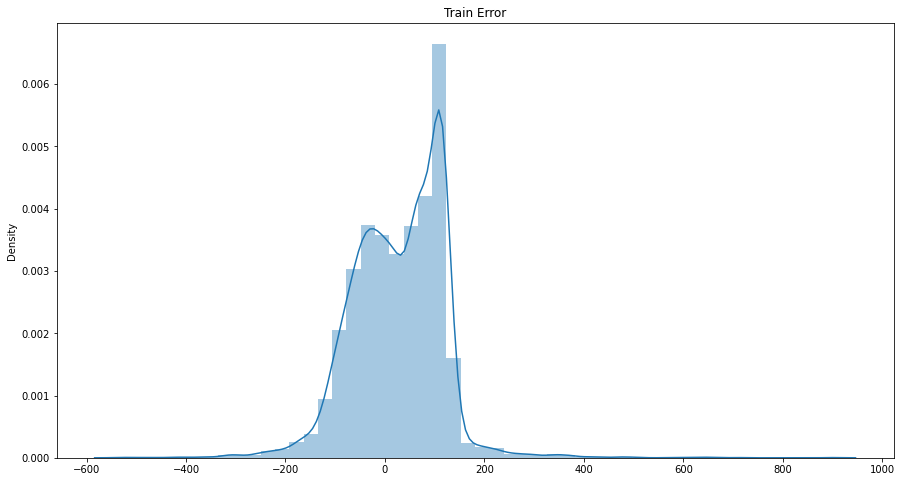

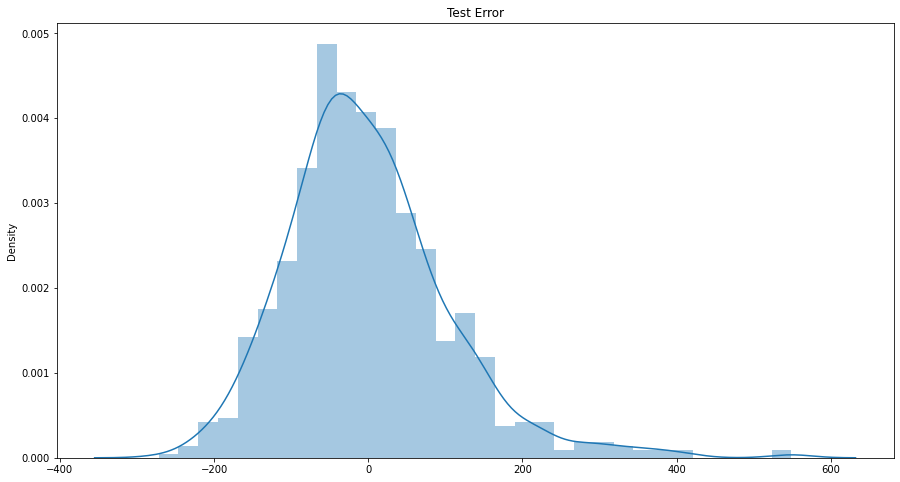

10
mse_of_pred: 61.90 | rmse_of_pred: 7.87
Epoch 1/50
30/30 [==============================] - 4s 135ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 3.2014e-04 - val_mean_squared_error: 3.2014e-04
Epoch 2/50
30/30 [==============================] - 4s 134ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 4.2185e-04 - val_mean_squared_error: 4.2185e-04
Epoch 3/50
30/30 [==============================] - 4s 134ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.6762e-04 - val_mean_squared_error: 3.6762e-04
Epoch 4/50
30/30 [==============================] - 4s 132ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.5678e-04 - val_mean_squared_error: 3.5678e-04
Epoch 5/50
30/30 [==============================] - 4s 133ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.0949e-04 - val_mean_squared_error: 3.0949e-04
Epoch 6/50
30/30 [==============================] - 4s 135ms/step - loss: 0.0012 - mean_squared_error: 0.00

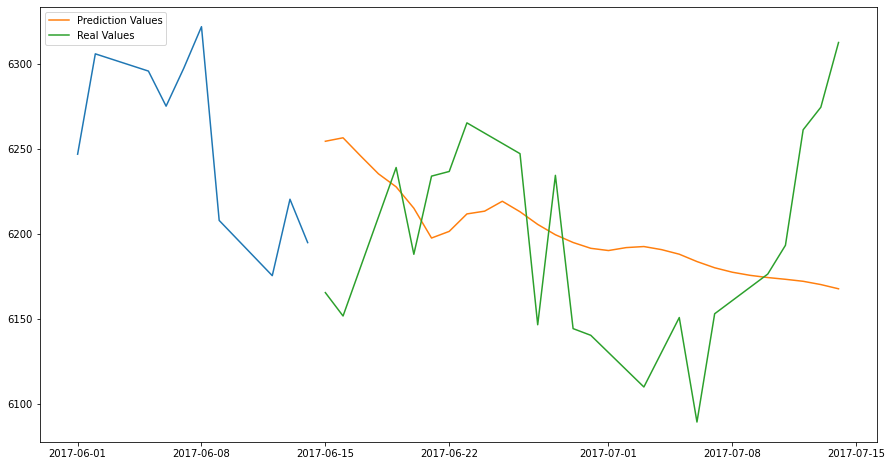

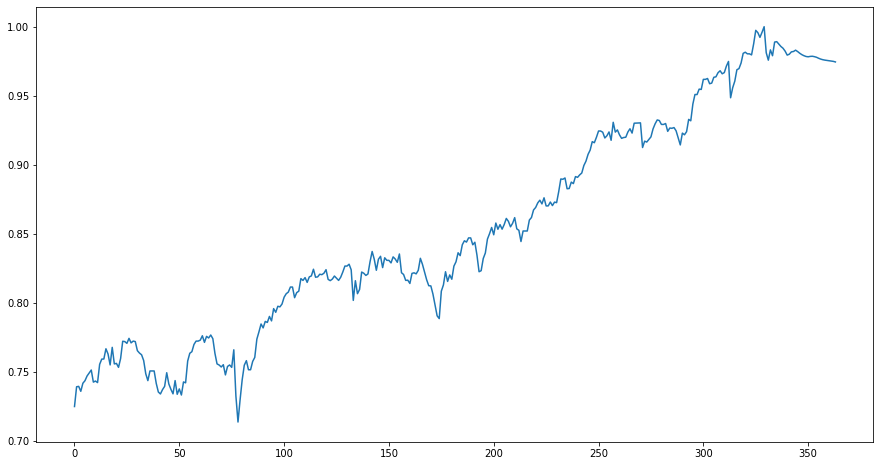

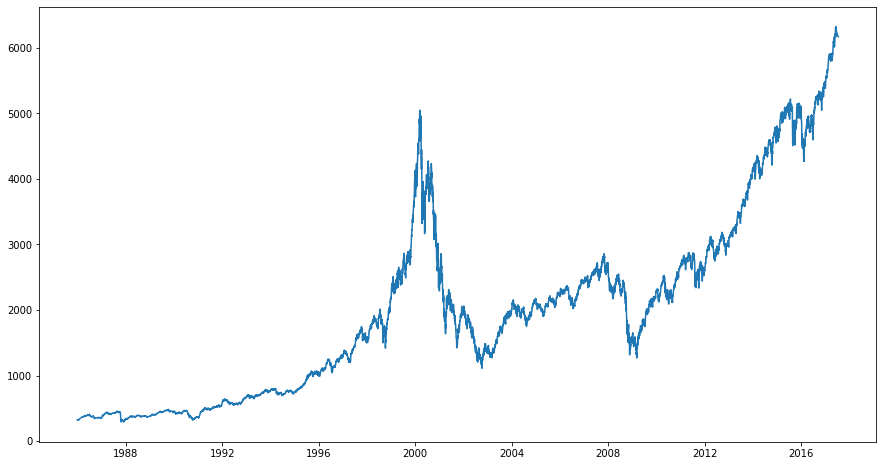

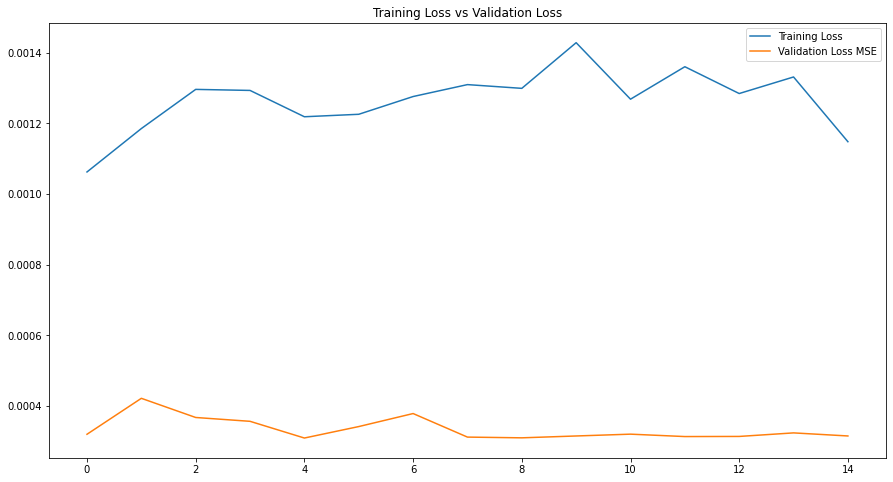

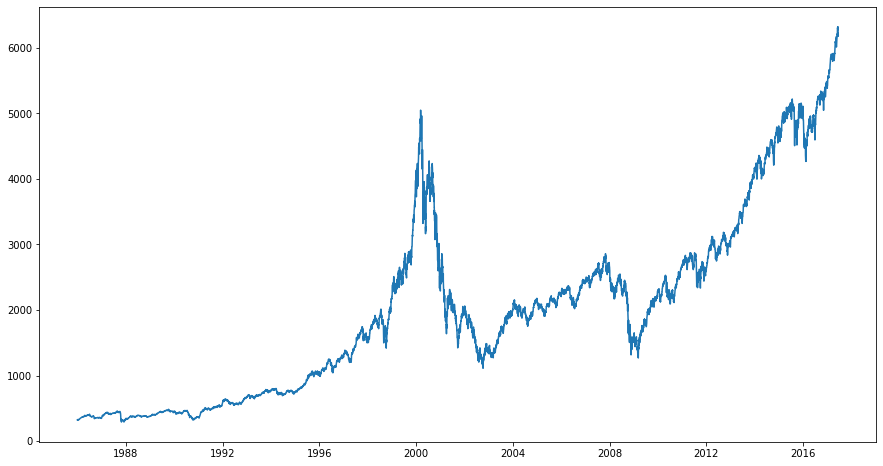

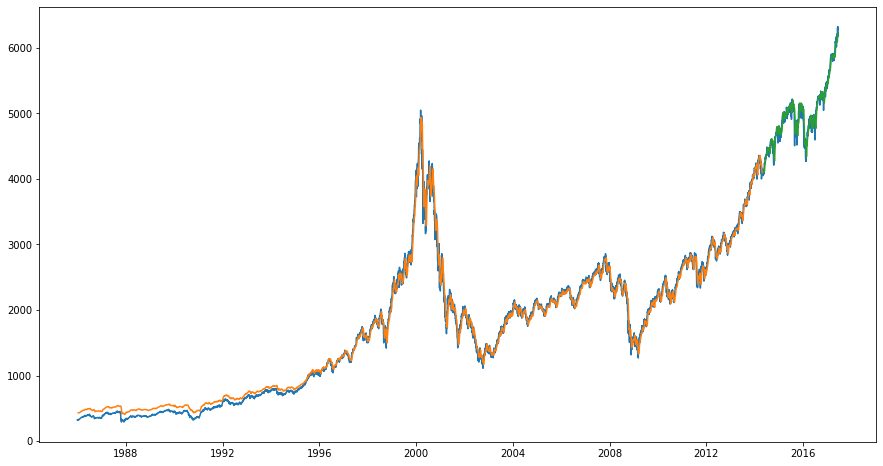

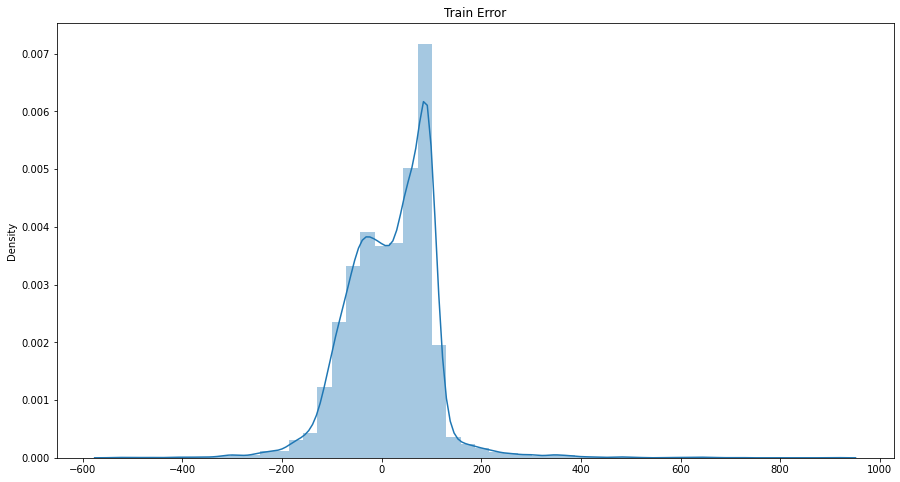

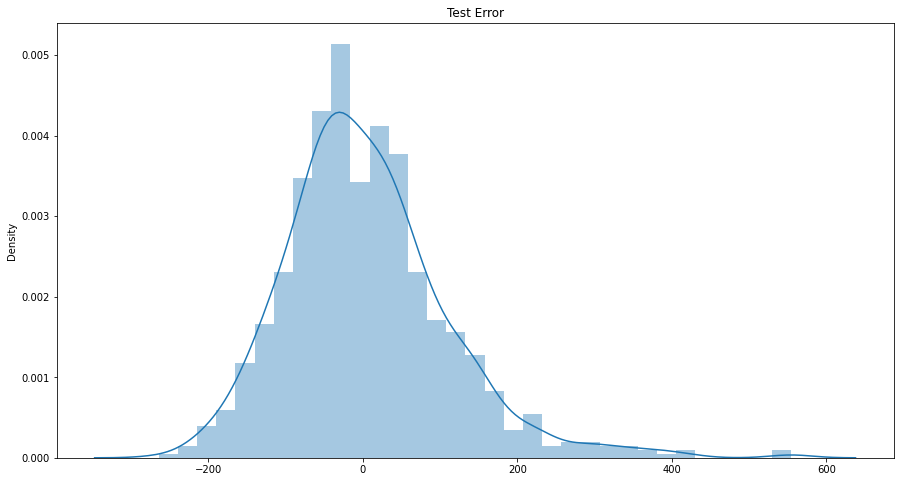

10
mse_of_pred: 61.80 | rmse_of_pred: 7.86


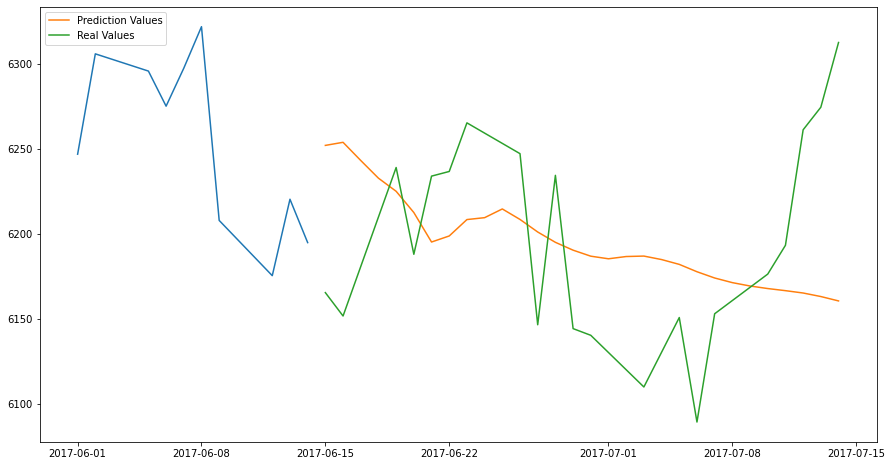

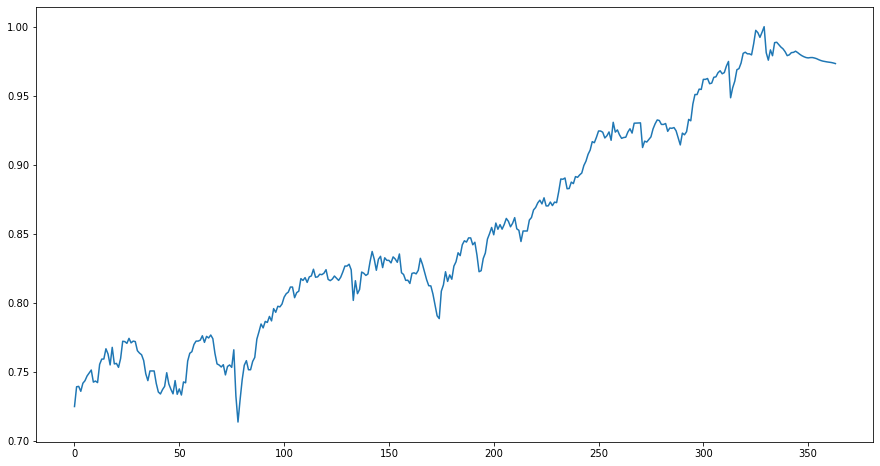

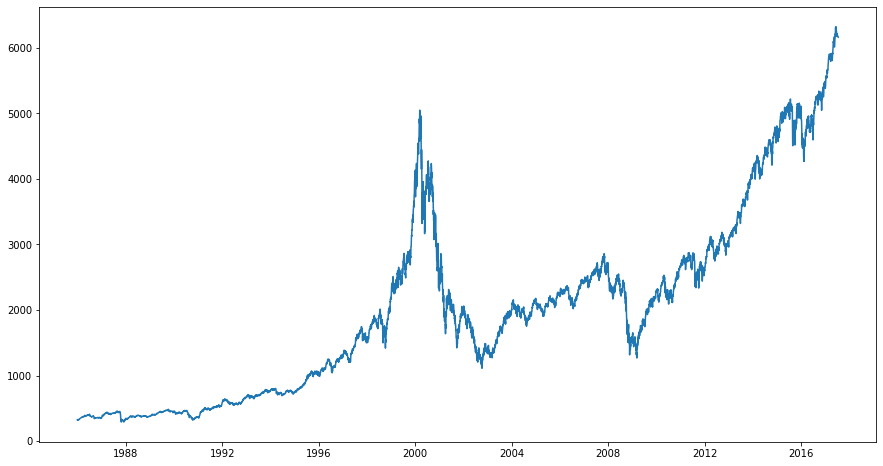

In [ ]:
for ep in range (1, 6, 1):
  history = model.fit(X_train, 
                y_train, 
                validation_data=(X_test,ytest), 
                epochs=50, 
                batch_size=250, 
                shuffle=False,
                callbacks=[early_stopping],
                verbose=1) 
  ### prediction
  train_predict=model.predict(X_train)
  test_predict=model.predict(X_test)  
  
  # rescaled of predictions
  train_predict=scaler.inverse_transform(train_predict)
  test_predict=scaler.inverse_transform(test_predict) 

  # rescaled for train and test error graphs
  y_train = y_train.reshape(-1,1)
  ytest = ytest.reshape(-1,1)

  y_train_rescaled=scaler.inverse_transform(y_train).squeeze()
  ytest_rescaled=scaler.inverse_transform(ytest).squeeze()


  # Calculation of MSE
  train_mse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train),train_predict))
  test_mse = math.sqrt(mean_squared_error(scaler.inverse_transform(ytest),test_predict))
  print(f'Train MSE: {train_mse:.2f} | Test MSE: {test_mse:.2f}')

  plt.figure(figsize=(15,8))
  plt.title("Training Loss vs Validation Loss")
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss MSE')
  plt.legend()


  
  plt.figure(figsize=(15,8))
  uni_data_dates=uni_data['Date'] 
  uni_data_dates = pd.DataFrame(uni_data_dates)
  uni_data_dates
  print(uni_data_dates.info())
  plt.plot(uni_data_dates, uni_data['Close'])


  # Plotting the prediction results of Train and Test
  plt.subplots(figsize=(15, 8))
  look_back=time_step


  # shift train predictions for plotting
  trainPredictPlot = numpy.empty_like(uni_data_close)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict


  # shift test predictions for plotting
  testPredictPlot = numpy.empty_like(uni_data_close)
  testPredictPlot[:, :] = numpy.nan
  testPredictPlot[len(train_predict)+(look_back*2)+1:len(uni_data_close)-1, :] = test_predict


  # plot baseline and predictions
  plt.plot(uni_data_dates, scaler.inverse_transform(uni_data_close))
  plt.plot(uni_data_dates, trainPredictPlot)
  plt.plot(uni_data_dates, testPredictPlot)
  plt.show()  

  #Train Error
  fig=plt.figure(figsize=(15,8))    
  sns.distplot(train_predict.squeeze() - y_train_rescaled)
  plt.title('Train Error')
  plt.show()

  #Test Error
  plt.figure(figsize=(15,8))    
  sns.distplot(test_predict.squeeze() - ytest_rescaled)
  plt.title('Test Error')
  plt.show()

  x_input=test_data[len(test_data) - time_step:].reshape(1,-1) 
  x_input.shape

  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()
  print(len(temp_input))
  temp_input  



  # prediction for next 30 days
  from numpy import array

  lst_output=[]
  n_steps= look_back
  i=0
  while(i<30):
    
      if(len(temp_input)>n_steps):
          #print(temp_input)
          x_input=np.array(temp_input[1:])
          #print("{} day input {}".format(i,x_input))
          x_input=x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1))
          #print(x_input)
          yhat = model.predict(x_input, verbose=0)
          #print("{} day output {}".format(i,yhat))
          temp_input.extend(yhat[0].tolist())
          temp_input=temp_input[1:]
          #print(temp_input)
          lst_output.extend(yhat.tolist())
          i=i+1
      else:
          x_input = x_input.reshape((1, n_steps,1))
          yhat = model.predict(x_input, verbose=0)
          #print(yhat[0])
          temp_input.extend(yhat[0].tolist())
          #print(len(temp_input))
          lst_output.extend(yhat.tolist())
          i=i+1



  day_new=np.arange(1,n_steps+1)
  day_pred=np.arange(n_steps+1,n_steps+31)
  day_new2 = uni_data['Date'][len(uni_data_close)-time_step:]
  day_new2 = day_new2.array
  day_new2
  import datetime
  first_day_of_prediction = day_new2[-1] + datetime.timedelta(days=1)

  end_day_of_prediction = day_new2[-1] + datetime.timedelta(days=30)
  first_day_of_prediction, end_day_of_prediction
  day_pred2 = pd.Series(pd.date_range(first_day_of_prediction, freq="D", periods=len(lst_output))).array
  day_pred2
  prediction_results = scaler.inverse_transform(lst_output)
  def real_results_prediction(table):
      table = table.loc[(table['Date'] >= first_day_of_prediction) & (table['Date'] <= end_day_of_prediction)] 
      table.reset_index(inplace=True, drop=True)
      return table
  nasdaq_comparison = real_results_prediction(nasdaq_all)
  nasdaq_comparison
  data = {'Date':  day_pred2}

  prediction_data = pd.DataFrame (data, columns = ['Date'])

  prediction_data['Predictions'] = prediction_results
  prediction_data
  comparison_data = pd.merge(prediction_data, nasdaq_comparison, how ="outer", on=["Date"]) 
  comparison_data.update(comparison_data.Close.interpolate())
  comparison_data = comparison_data[['Date', 'Predictions', 'Close']]
  comparison_data

  mse_of_pred = math.sqrt(mean_squared_error(comparison_data.Close,comparison_data.Predictions))
  mse_of_pred


  rmse_of_pred = math.sqrt(mse_of_pred)
  rmse_of_pred
  print(f'mse_of_pred: {mse_of_pred:.2f} | rmse_of_pred: {rmse_of_pred:.2f}')


  # Graph of next 30 days prediction
  plt.figure(figsize=(15,8)) 


  plt.plot(day_new2, scaler.inverse_transform(uni_data_close[len(uni_data_close)-time_step:]))
  plt.plot(day_pred2, comparison_data.Predictions, label = 'Prediction Values')
  plt.plot(day_pred2, comparison_data.Close, label = 'Real Values')
  plt.legend();

  # scaled graph
  plt.figure(figsize=(15,8)) 
  uni_data_res=uni_data_close.tolist()
  uni_data_res.extend(lst_output)
  uni_data_res_dates = uni_data_dates.squeeze().tolist()
  uni_data_res_dates.extend(day_pred2)
  uni_data_res_dates = np.array(uni_data_res_dates)
  plt.plot(uni_data_res[8000:])



  uni_data_res_dates = uni_data_dates.squeeze().tolist()
  uni_data_res_dates.extend(day_pred2)
  uni_data_res_dates[-1] 



  uni_data_res=scaler.inverse_transform(uni_data_res).tolist()



  plt.figure(figsize=(15,8)) 
  plt.plot(uni_data_res_dates, uni_data_res)






In [ ]:
### prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
# rescaled of predictions
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
# rescaled for train and test error graphs
y_train = y_train.reshape(-1,1)
ytest = ytest.reshape(-1,1)

y_train_rescaled=scaler.inverse_transform(y_train).squeeze()
ytest_rescaled=scaler.inverse_transform(ytest).squeeze()


In [ ]:
# Calculation of MSE
train_mse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train),train_predict))
test_mse = math.sqrt(mean_squared_error(scaler.inverse_transform(ytest),test_predict))
print(f'Train MSE: {train_mse:.2f} | Test MSE: {test_mse:.2f}')

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training Loss vs Validation Loss")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss MSE')
plt.legend()

In [ ]:
### prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
# rescaled of predictions
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
# rescaled for train and test error graphs
y_train = y_train.reshape(-1,1)
ytest = ytest.reshape(-1,1)

y_train_rescaled=scaler.inverse_transform(y_train).squeeze()
ytest_rescaled=scaler.inverse_transform(ytest).squeeze()


In [ ]:
# Calculation of MSE
train_mse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train),train_predict))
test_mse = math.sqrt(mean_squared_error(scaler.inverse_transform(ytest),test_predict))
print(f'Train MSE: {train_mse:.2f} | Test MSE: {test_mse:.2f}')

In [ ]:
time_step

In [ ]:
len(train_predict), len(uni_data_close)

In [ ]:
plt.figure(figsize=(15,8))
uni_data_dates=uni_data['Date'] 
uni_data_dates = pd.DataFrame(uni_data_dates)
uni_data_dates
print(uni_data_dates.info())

plt.plot(uni_data_dates, uni_data['Close'])

In [ ]:
# Plotting the prediction results of Train and Test
plt.subplots(figsize=(15, 8))
look_back=time_step

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(uni_data_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(uni_data_close)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(uni_data_close)-1, :] = test_predict

# plot baseline and predictions
plt.plot(uni_data_dates, scaler.inverse_transform(uni_data_close))
plt.plot(uni_data_dates, trainPredictPlot)
plt.plot(uni_data_dates, testPredictPlot)
plt.show()

In [ ]:
#Train Error
fig=plt.figure(figsize=(15,8))    

sns.distplot(train_predict.squeeze() - y_train_rescaled)
plt.title('Train Error')
plt.show()

In [ ]:
#Test Error
plt.figure(figsize=(15,8))    

sns.distplot(test_predict.squeeze() - ytest_rescaled)
plt.title('Test Error')
plt.show()

## Next 30 days Predictions

In [ ]:
x_input=test_data[len(test_data) - time_step:].reshape(1,-1) 
x_input.shape

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(len(temp_input))
temp_input

In [ ]:
# prediction for next 30 days
from numpy import array

lst_output=[]
n_steps= look_back
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [ ]:
print(len(lst_output))
lst_output

## DataFrame of Prediction results

In [ ]:
day_new=np.arange(1,n_steps+1)
day_pred=np.arange(n_steps+1,n_steps+31)
day_new2 = uni_data['Date'][len(uni_data_close)-time_step:]
day_new2 = day_new2.array
day_new2

In [ ]:
day_new2 = uni_data['Date'][len(uni_data_close)-time_step:]
day_new2 = day_new2.array
day_new2

In [ ]:
import datetime
first_day_of_prediction = day_new2[-1] + datetime.timedelta(days=1)

end_day_of_prediction = day_new2[-1] + datetime.timedelta(days=30)
first_day_of_prediction, end_day_of_prediction

In [ ]:
day_pred2 = pd.Series(pd.date_range(first_day_of_prediction, freq="D", periods=len(lst_output))).array
day_pred2

In [ ]:
prediction_results = scaler.inverse_transform(lst_output)

In [ ]:
def real_results_prediction(table):
    table = table.loc[(table['Date'] >= first_day_of_prediction) & (table['Date'] <= end_day_of_prediction)] 
    table.reset_index(inplace=True, drop=True)
    return table
nasdaq_comparison = real_results_prediction(nasdaq_all)
nasdaq_comparison

In [ ]:
data = {'Date':  day_pred2}

prediction_data = pd.DataFrame (data, columns = ['Date'])

prediction_data['Predictions'] = prediction_results
prediction_dataz

In [ ]:
comparison_data = pd.merge(prediction_data, nasdaq_comparison, how ="outer", on=["Date"]) 
comparison_data.update(comparison_data.Close.interpolate())
comparison_data = comparison_data[['Date', 'Predictions', 'Close']]
comparison_data

## Evaluation of Prediction results

In [ ]:
mse_of_pred = math.sqrt(mean_squared_error(comparison_data.Close,comparison_data.Predictions))
mse_of_pred

In [ ]:
rmse_of_pred = math.sqrt(mse_of_pred)
rmse_of_pred

## Graphs of Prediction Results

In [ ]:
# Graph of next 30 days prediction
plt.figure(figsize=(15,8)) 


plt.plot(day_new2, scaler.inverse_transform(uni_data_close[len(uni_data_close)-time_step:]))
plt.plot(day_pred2, comparison_data.Predictions, label = 'Prediction Values')
plt.plot(day_pred2, comparison_data.Close, label = 'Real Values')
plt.legend();

In [ ]:
# scaled graph

plt.figure(figsize=(15,8)) 
uni_data_res=uni_data_close.tolist()
uni_data_res.extend(lst_output)
uni_data_res_dates = uni_data_dates.squeeze().tolist()
uni_data_res_dates.extend(day_pred2)
uni_data_res_dates = np.array(uni_data_res_dates)
plt.plot(uni_data_res[8000:])

In [ ]:
uni_data_res_dates = uni_data_dates.squeeze().tolist()
uni_data_res_dates.extend(day_pred2)
uni_data_res_dates[-1] 

In [ ]:
uni_data_res=scaler.inverse_transform(uni_data_res).tolist()

In [ ]:
len(uni_data_res), len(uni_data_res_dates)

In [ ]:
plt.figure(figsize=(15,8)) 
plt.plot(uni_data_res_dates, uni_data_res)